# Advanced Machine Learning Project

## Fingerprint generation using diffusion networks

    Ayush Abrol B20AI052
    Aryan Tiwari B20AI056
    Udit Agarwal B20ME076

---

### Necessary Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision.transforms as T
import cv2 as cv2
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import copy
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import optim
import logging
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from torch.cuda.amp import autocast

In [2]:
# real_data = "/home/ayushabrol/Desktop/AML/Project/archive/socofing/SOCOFing/Real"
# altered_data = "/home/ayushabrol/Desktop/AML/Project/archive/socofing/SOCOFing/Altered"

## Exploratory data analysis (EDA)

1. The real data contain 6000 fingerprint for 600 subject as every subject has 10 fingerprints that represents the five fingers for every hand.
2. The altered data is the same data with some augmentation.
3. There are three differnt versions of the altered data : easy-medium-hard.
4. The augmentation of the data is : obliteration, central rotation, and z-cut.
5. The names for every photo is in format [(subjectindex)(gender)_(finger_name).BMP]
6. The finger names with their corresponding labels are:
    1) index_finger ----> 0
    2) little_finger ----> 1
    3) middle_finger ----> 2
    4) ring_finger ----> 3
    5) thumb_finger ----> 4

We will use the real and altered data to construct the Diffusin Network model.

The altered data will be used to determine the distance threshold .

In [3]:
classes = {0:"index", 1:"little", 2:"middle", 3:"ring", 4:"thumb"}

### Data Preprocessing and Categorization for Hand Fingerprint Recognition Dataset

The code iterates through grayscale images in a directory, resizes them to 128x128 pixels, and categorizes them based on a naming convention. Images with specific names are sorted into five folders representing different finger types. It organizes real hand fingerprint images from various difficulty levels into corresponding folders, creating a dataset structure for the project. The resized images are saved in a destination directory based on finger type, facilitating the preparation of data for a machine learning task related to hand gesture recognition.

In [4]:
# photos_names = os.listdir(real_data)
# for name in photos_names:
#     # data.append(cv.imread(os.path.join(real_data ,name) ,cv.IMREAD_GRAYSCALE))
#     print(name)
#     img_path = os.path.join(real_data ,name)
#     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     if img is not None:
#         img_resized = cv2.resize(img, (128, 128))
#         temp = name.split("_")[4]
#         if temp == "index" : cv2.imwrite(r"/home/ayushabrol/Desktop/AML/Project/dataset/0/"+ name[:-4] + ".png", img_resized)
#         elif temp == "little" : cv2.imwrite(r"/home/ayushabrol/Desktop/AML/Project/dataset/1/"+ name[:-4] + ".png", img_resized)
#         elif temp == "middle" : cv2.imwrite(r"/home/ayushabrol/Desktop/AML/Project/dataset/2/"+ name[:-4] + ".png", img_resized)
#         elif temp == "ring" : cv2.imwrite(r"/home/ayushabrol/Desktop/AML/Project/dataset/3/"+ name[:-4] + ".png", img_resized)
#         else : cv2.imwrite(r"/home/ayushabrol/Desktop/AML/Project/dataset/4/"+ name[:-4] + ".png", img_resized)

# # load the altered data and their labels
# dirs = ["Altered-Easy" ,"Altered-Hard" ,"Altered-Medium"]
# for folder in dirs:
#     photos_names = os.listdir(os.path.join(altered_data ,folder))
#     for name in photos_names:
#         # data.append(cv.imread(os.path.join(altered_data ,folder ,name) ,cv.IMREAD_GRAYSCALE))
#         img_path = os.path.join(real_data ,name)
#         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#         if img is not None:
#             img_resized = cv2.resize(img, (128, 128))
#             temp = name.split("_")[4]
#             if temp == "index" : cv2.imwrite(r"/home/ayushabrol/Desktop/AML/Project/dataset/0/" + name[:-4] + ".png", img_resized)
#             elif temp == "little" : cv2.imwrite(r"/home/ayushabrol/Desktop/AML/Project/dataset/1/"+ name[:-4] + ".png", img_resized)
#             elif temp == "middle" : cv2.imwrite(r"/home/ayushabrol/Desktop/AML/Project/dataset/2/"+ name[:-4] + ".png", img_resized)
#             elif temp == "ring" : cv2.imwrite(r"/home/ayushabrol/Desktop/AML/Project/dataset/3/"+ name[:-4] + ".png", img_resized)
#             else : cv2.imwrite(r"/home/ayushabrol/Desktop/AML/Project/dataset/4/"+ name[:-4] + ".png", img_resized)

In [5]:
import torchvision
from torch.utils.data import DataLoader

## Heading: Custom Image Dataset Creation and DataLoader Initialization

This code defines a custom PyTorch dataset (`Fingerprint Dataset`) for image processing and subsequently creates a DataLoader for efficient batch loading. The dataset class inherits from `torch.utils.data.Dataset` and wraps an `ImageFolder` dataset, allowing customization of image transformations. Images are loaded, resized, and converted to float16 within the dataset. The DataLoader is then configured with batch size, shuffling, and other parameters, providing a convenient interface for iterating through batches of the processed images and their corresponding labels. This setup is suitable for tasks like image classification or deep learning model training on custom image datasets.

In [6]:
"""image_size = 64
dataset_path = "dataset"
batch_size = 64

transforms = torchvision.transforms.Compose([
        torchvision.transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.Resize(80),  # args.image_size + 1/4 *args.image_size
        torchvision.transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor()
    ])
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transforms)

for i in range(len(dataset)):
    image, label = dataset[i]
    dataset[i] = (image.to(dtype=torch.float16), label)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)"""

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset

class CustomImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = torchvision.datasets.ImageFolder(root, transform=transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        # Convert the image to float16
        image = image.to(dtype=torch.float16)

        return image, label

# Specify your dataset path and other parameters
dataset_path = "dataset"
batch_size = 4
image_size = 64  # Replace with your desired image size

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Resize(80),  # args.image_size + 1/4 *args.image_size
    torchvision.transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    torchvision.transforms.ToTensor()
])

# Create an instance of the custom dataset
custom_dataset = CustomImageDataset(root=dataset_path, transform=transforms)

# Create a DataLoader
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)


## Visualization of the data

In [7]:
"""import matplotlib.pyplot as plt

# Visualize the data
data, labels = next(iter(dataloader))

# Plot the images
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
axes = axes.flatten()

for i in range(len(data)):
    image = data[i].permute(1, 2, 0).numpy()
    axes[i].imshow(image)
    # Show the image label
    axes[i].set_title(classes[int(labels[i])])
    axes[i].axis('off')

plt.show()"""

"import matplotlib.pyplot as plt\n\n# Visualize the data\ndata, labels = next(iter(dataloader))\n\n# Plot the images\nfig, axes = plt.subplots(8, 8, figsize=(16, 16))\naxes = axes.flatten()\n\nfor i in range(len(data)):\n    image = data[i].permute(1, 2, 0).numpy()\n    axes[i].imshow(image)\n    # Show the image label\n    axes[i].set_title(classes[int(labels[i])])\n    axes[i].axis('off')\n\nplt.show()"

## Model Architecture

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

This class implements an Exponential Moving Average (EMA) technique for model parameter averaging, often used in deep learning. Here's a breakdown:

1. Initialization: The class is initialized with a beta parameter, which controls the weight given to the current model parameters when updating the moving average.

2. update_model_average Method: Updates the moving average model's parameters based on the current model's parameters. It iterates through corresponding parameters in both models and applies the EMA update.

3. update_average Method: Computes the EMA update for an individual parameter.

4. step_ema Method: Advances the EMA step. If the current step is below a specified threshold (step_start_ema), it resets the parameters of the EMA model to match the current model. Otherwise, it updates the EMA model's parameters.

5. reset_parameters Method: Resets the parameters of the EMA model to match the current model.

In [9]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

This class defines a self-attention mechanism implemented as a PyTorch module. Here's a breakdown of its components and functionality:

1. Initialization: The class is initialized with the number of channels and the spatial dimension size. It consists of a multi-head self-attention mechanism (nn.MultiheadAttention), layer normalization (nn.LayerNorm), and a feedforward neural network.

2. forward Method: Defines the forward pass of the self-attention module. The input x is reshaped and processed through layer normalization. The multi-head self-attention mechanism (self.mha) is applied to the normalized input. The result is added to the original input (x). Then, a feedforward neural network (self.ff_self) is applied to the sum, and the final result is reshaped back to the original dimensions.

In [10]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

This class defines a double convolutional block as a PyTorch module. Here's an explanation of its functionality:

1. Initialization: The class is initialized with parameters for the number of input channels (in_channels), output channels (out_channels), optional middle channels (mid_channels), and a flag for residual connections (residual).

2. forward Method: Defines the forward pass of the double convolutional block. It consists of two convolutional layers with Group Normalization and GELU activation functions. If the residual flag is set, the block applies a skip connection, adding the original input to the output after the second convolutional layer.

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


This class represents a downsampling block within a neural network architecture. Here's a breakdown of its components and functionality:

1. Initialization: The class is initialized with parameters for the number of input channels (in_channels), the number of output channels (out_channels), and an optional embedding dimension (emb_dim) defaulting to 256. It consists of two main components: a downsampling block (maxpool_conv) and an embedding layer (emb_layer).

2. maxpool_conv Sequential Block: This block performs downsampling using max-pooling (nn.MaxPool2d(2)) followed by two consecutive double convolutional blocks (DoubleConv). The first double convolutional block has a residual connection (residual=True), and the second does not.

3. emb_layer Sequential Block: This block is an embedding layer. It applies a SiLU activation function (nn.SiLU()) followed by a linear layer (nn.Linear) that maps the embedding dimension (emb_dim) to the number of output channels (out_channels).

4. forward Method: Defines the forward pass of the downsampling block. It first passes the input tensor (x) through the maxpool_conv block. Then, it generates an embedding (emb) from an auxiliary input tensor (t) using the emb_layer. The embedding is spatially broadcasted to match the dimensions of the downsampled tensor (x). The output is the sum of the downsampled tensor and the spatially broadcasted embedding.

In [12]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


This class represents an upsampling block within a neural network architecture. Here's a breakdown of its components and functionality:

1. Initialization: The class is initialized with parameters for the number of input channels (in_channels), the number of output channels (out_channels), and an optional embedding dimension (emb_dim) defaulting to 256. It consists of three main components: an upsampling layer (up), a double convolutional block (conv), and an embedding layer (emb_layer).

2. up Upsampling Layer: This layer performs upsampling using bilinear interpolation (nn.Upsample). It doubles the spatial dimensions of the input tensor.

3. conv Sequential Block: This block consists of two consecutive double convolutional blocks (DoubleConv). The first double convolutional block has a residual connection (residual=True). The second block has a specified number of mid-channels (in_channels // 2).

4. emb_layer Sequential Block: Similar to the Down class, this block is an embedding layer. It applies a SiLU activation function (nn.SiLU()) followed by a linear layer (nn.Linear) that maps the embedding dimension (emb_dim) to the number of output channels (out_channels).

5. forward Method: Defines the forward pass of the upsampling block. It first upsamples the input tensor (x) using the up layer. The upsampled tensor is concatenated with a skip connection tensor (skip_x) along the channel dimension. The concatenated tensor is then processed through the conv block. An embedding (emb) is generated from an auxiliary input tensor (t) using the emb_layer. The embedding is spatially broadcasted to match the dimensions of the upsampled tensor, and the output is the sum of the upsampled tensor and the spatially broadcasted embedding.

In [13]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


This class defines a U-Net architecture with self-attention mechanisms and positional encoding for video data processing. Here's a breakdown of its components and functionality:

1. Initialization: The class is initialized with parameters for the number of input channels (c_in), the number of output channels (c_out), the temporal dimension (time_dim), and the device for computation (device). It consists of an encoder (downsampling path), a bottleneck, and a decoder (upsampling path). Self-attention blocks (sa1, sa2, sa3, sa4, sa5, sa6) are integrated into the architecture.

2. pos_encoding Method: Generates positional encoding based on the input temporal dimension (t). This encoding is used to provide the model with information about the order of sequences in time.

3. forward Method: Defines the forward pass of the U-Net. It incorporates the positional encoding generated from the temporal input t. The encoder (inc, down1, down2, down3) downsamples the input tensor. Self-attention mechanisms (sa1, sa2, sa3) are applied after each downsampling step. The bottleneck (bot1, bot2, bot3) captures high-level features. The decoder (up1, up2, up3) performs upsampling, and self-attention mechanisms (sa4, sa5, sa6) are applied after each upsampling step. The output is obtained through a 1x1 convolution (outc).

4. forward Method (continued): The temporal information is encoded using the pos_encoding method and is used in conjunction with the input tensor throughout the U-Net architecture. The self-attention mechanisms help capture long-range dependencies, and the positional encoding assists in handling sequential information in video data.

In [14]:
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')


This code defines a conditional U-Net architecture for image-to-image translation with an optional class label as additional input. Here's a breakdown of its components and functionality:

1. Initialization: The class is initialized with parameters for the number of input channels (c_in), the number of output channels (c_out), the temporal dimension (time_dim), the number of classes (num_classes), and the device for computation (device). It extends the original U-Net architecture with a conditional input for class labels.

2. label_emb Embedding Layer: If the number of classes is provided (num_classes is not None), an embedding layer (label_emb) is created to convert class labels into a temporal embedding of dimension time_dim. This temporal embedding is added to the positional encoding.

3. forward Method: Defines the forward pass of the conditional U-Net. It incorporates the positional encoding generated from the temporal input t. If class labels (y) are provided, their corresponding embeddings are added to the temporal embedding. The rest of the architecture remains similar to the original U-Net, including self-attention mechanisms and double convolutional blocks.

4. forward Method (continued): The temporal information is encoded using the pos_encoding method and is used in conjunction with the input tensor throughout the U-Net architecture. If class labels are provided, their embeddings are added to the temporal embedding. The self-attention mechanisms help capture long-range dependencies, and the positional encoding assists in handling sequential information in video data.

In [16]:
class UNet_conditional(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None, device=device):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [17]:
# net = UNet_conditional(num_classes=10, device=device).to(device)
# print(sum([p.numel() for p in net.parameters()]))

In [18]:
# x = torch.randn(1, 3, 64, 64).to(device)
# t = x.new_tensor([500] * x.shape[0]).long().to(device)
# y = x.new_tensor([1] * x.shape[0]).long().to(device)
# temp = net(x, t, y)

In [19]:
# import matplotlib.pyplot as plt

# # Convert the tensor to a numpy array
# image = x.squeeze().permute(1, 2, 0).detach().cpu().numpy()

# # Plot the image
# plt.imshow(image)
# plt.axis('off')
# plt.show()

In [20]:
# # Convert the tensor to a numpy array
# image = temp.squeeze().permute(1, 2, 0).detach().cpu().numpy()

# # Plot the image
# plt.imshow(image)
# plt.axis('off')
# plt.show()

This code defines a class named Diffusion that implements the denoising score matching method using diffusion models. Here's a breakdown of its components and functionality:

1. Initialization:

    1) noise_steps: Number of diffusion steps.
    2) beta_start, beta_end: Initial and final values of the noise level during diffusion.
    3) img_size: Size of the input images.
    4) device: Device on which to perform computations (default is "cuda").

2. prepare_noise_schedule Method: Generates a linear schedule of beta values (noise level) from beta_start to beta_end with noise_steps steps.

3. noise_images Method: Adds noise to the input images for a given diffusion step. Computes noise scaling factors using alpha and alpha_hat. Returns the noised images and the corresponding noise samples.

4. sample_timesteps Method: Randomly samples timesteps from 1 to noise_steps.

5. sample Method: Generates samples using the trained diffusion model. Iterates over the reversed range of diffusion steps. Adds noise to the initial random input images. Applies the trained diffusion model to generate predicted noise. Updates the input images using the diffusion process. Returns the generated samples.
In summary, this Diffusion class implements the denoising score matching method using diffusion models. 

In [21]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, labels, cfg_scale=3):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

This function is typically called at the beginning of a script or program to ensure that the necessary directories are available for storing model checkpoints, logs, or any other files associated with the current run. It helps organize the output and results of experiments, making it easier to manage and locate files related to specific runs.

In [22]:
def setup_logging(run_name):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("models", run_name), exist_ok=True)
    os.makedirs(os.path.join("results", run_name), exist_ok=True)

These functions are helpful for visualizing and saving batches of images in the context of deep learning experiments. The plot_images function is useful for quickly visualizing a set of images in a Jupyter notebook or similar environment. The save_images function is designed to save batches of images to a specified file path, which is common when saving generated images during training or evaluation of deep learning models.

In [23]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

Defining the hyperparameters for the training process 

In [35]:
run_name = "DDPM_conditional"
epochs = 30
batch_size = 4
image_size = 64
num_classes = 10
dataset_path = dataset_path
device = device
lr = 3e-4

Purpose:

The training loop iterates over epochs and batches, generating images with a diffusion model and optimizing the conditional U-Net based on the MSE loss between the generated and true noise. It also visualizes and saves generated images and checkpoints at certain intervals. The Exponential Moving Average (EMA) is used to stabilize the training process.


In [36]:
def train():
    setup_logging(run_name)
    # dataloader = get_data(
    model = UNet_conditional(num_classes=num_classes).to(device)
    ckpt = torch.load("models/DDPM_conditional/ckpt.pt")
    model.load_state_dict(ckpt)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=image_size, device=device)
    logger = SummaryWriter(os.path.join("runs", run_name))
    l = len(dataloader)
    ema = EMA(0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)

    for epoch in range(epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            if np.random.random() < 0.1:
                labels = None
            # with autocast(dtype=torch.float16):
            predicted_noise = model(x_t, t, labels)
            noise = noise.float()
            predicted_noise = predicted_noise.float()
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.step_ema(ema_model, model)

            pbar.set_postfix(MSE=loss.item())
            logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

        if epoch % 1 == 0:
            labels = torch.arange(10).long().to(device)
            sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
            ema_sampled_images = diffusion.sample(ema_model, n=len(labels), labels=labels)
            plot_images(sampled_images)
            save_images(sampled_images, os.path.join("results", run_name, f"{epoch+20}.jpg"))
            save_images(ema_sampled_images, os.path.join("results", run_name, f"{epoch+20}_ema.jpg"))
            torch.save(model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
            torch.save(ema_model.state_dict(), os.path.join("models", run_name, f"ema_ckpt.pt"))
            torch.save(optimizer.state_dict(), os.path.join("models", run_name, f"optim.pt"))

100%|██████████| 1500/1500 [01:56<00:00, 12.86it/s, MSE=0.00492] 
999it [01:48,  9.23it/s]
999it [01:49,  9.11it/s]


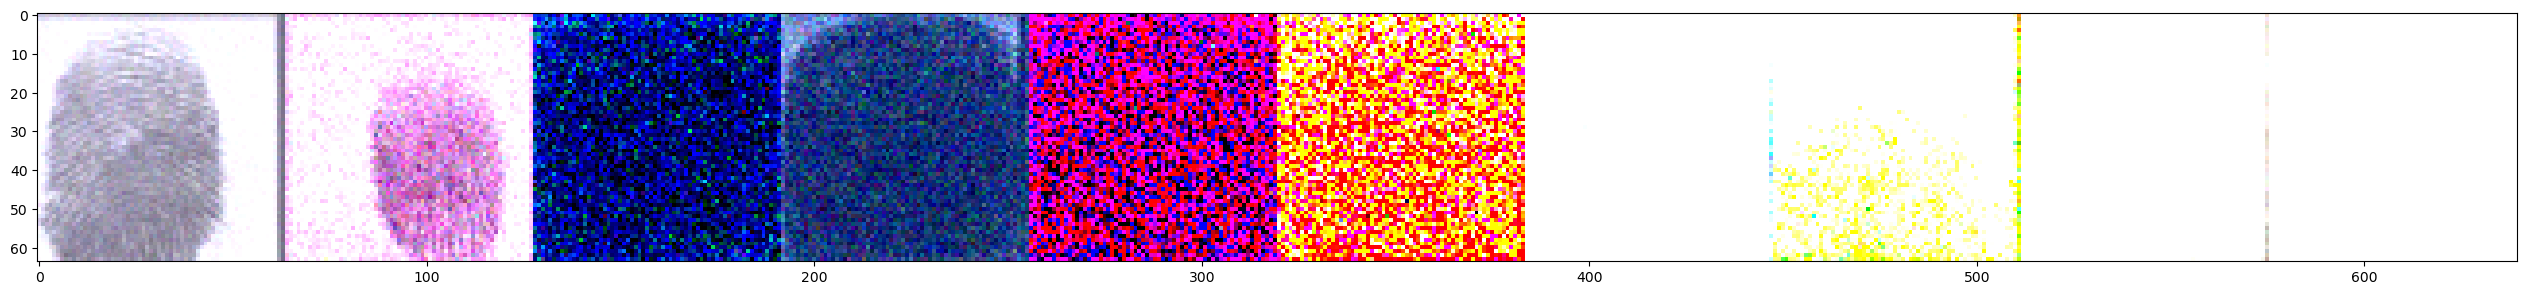

100%|██████████| 1500/1500 [01:56<00:00, 12.85it/s, MSE=0.00482] 
999it [01:50,  9.00it/s]
999it [01:49,  9.13it/s]


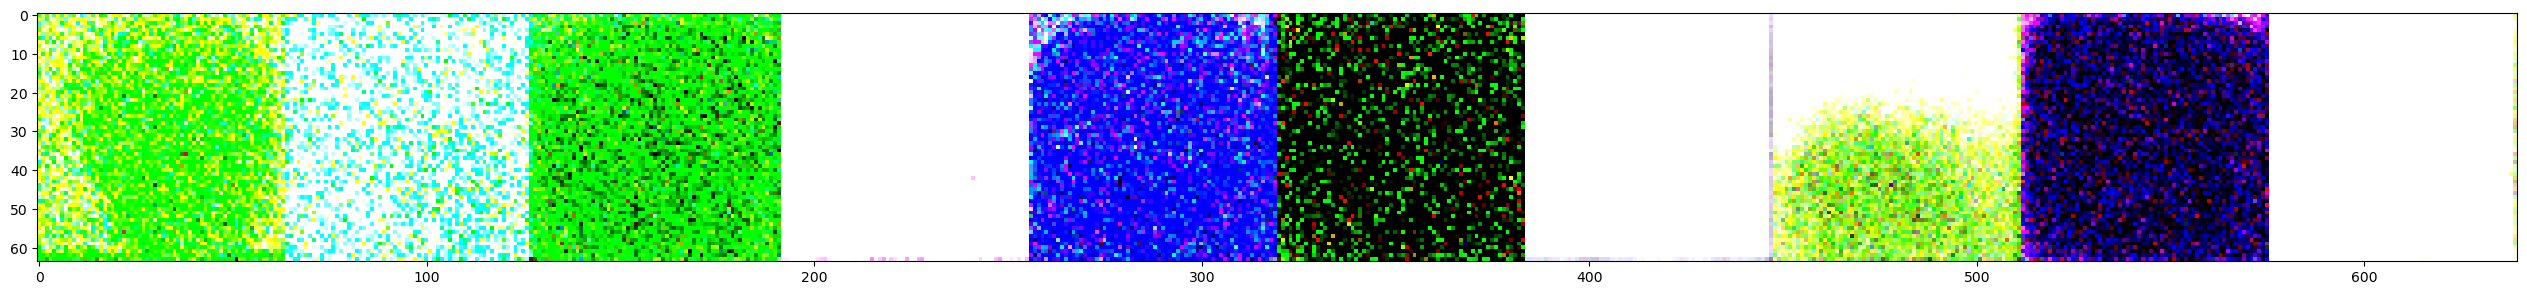

100%|██████████| 1500/1500 [02:01<00:00, 12.38it/s, MSE=0.0137]  
999it [01:49,  9.14it/s]
999it [01:46,  9.40it/s]


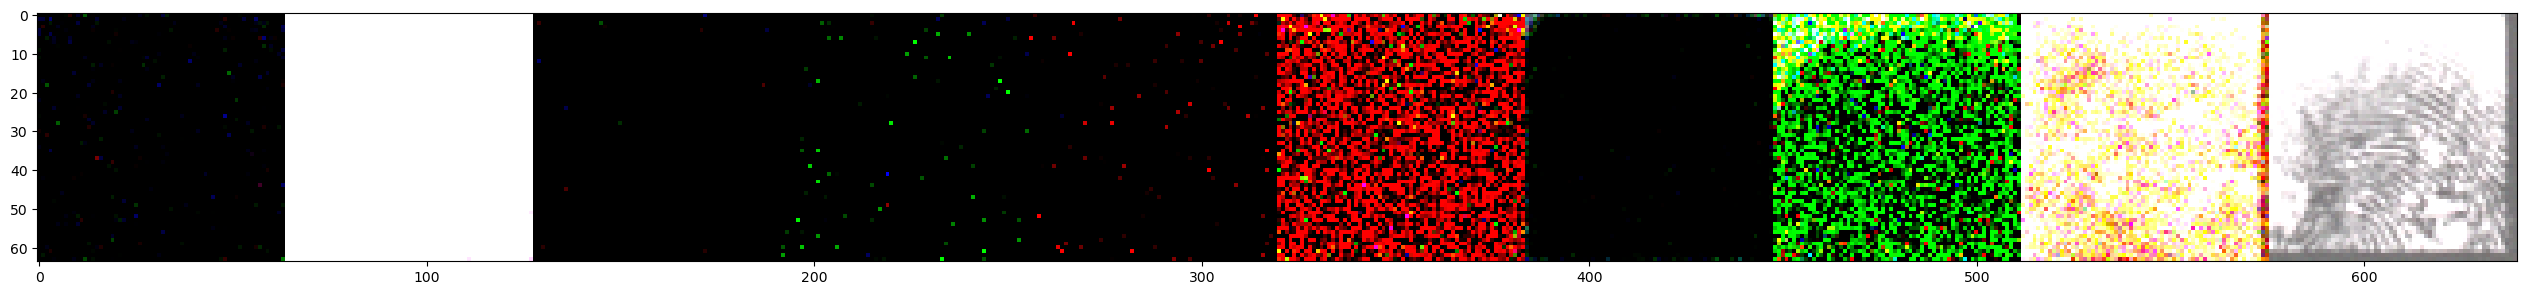

100%|██████████| 1500/1500 [01:57<00:00, 12.82it/s, MSE=0.00171] 
999it [01:48,  9.20it/s]
999it [01:50,  9.08it/s]


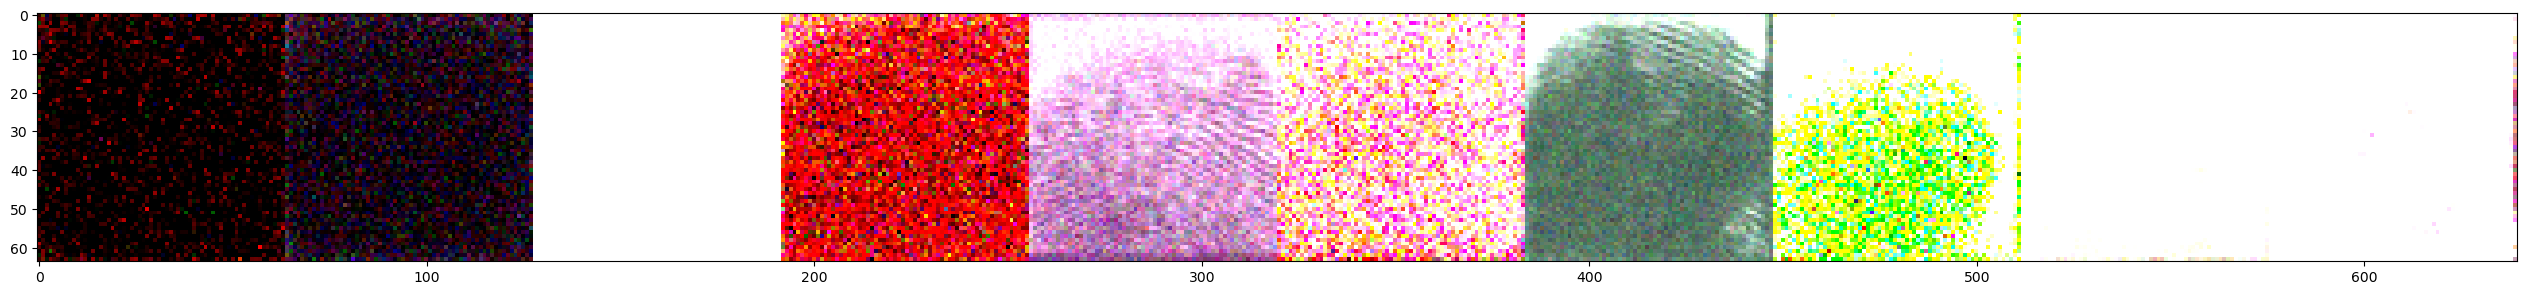

100%|██████████| 1500/1500 [01:59<00:00, 12.51it/s, MSE=0.028]   
999it [01:49,  9.15it/s]
999it [01:52,  8.85it/s]


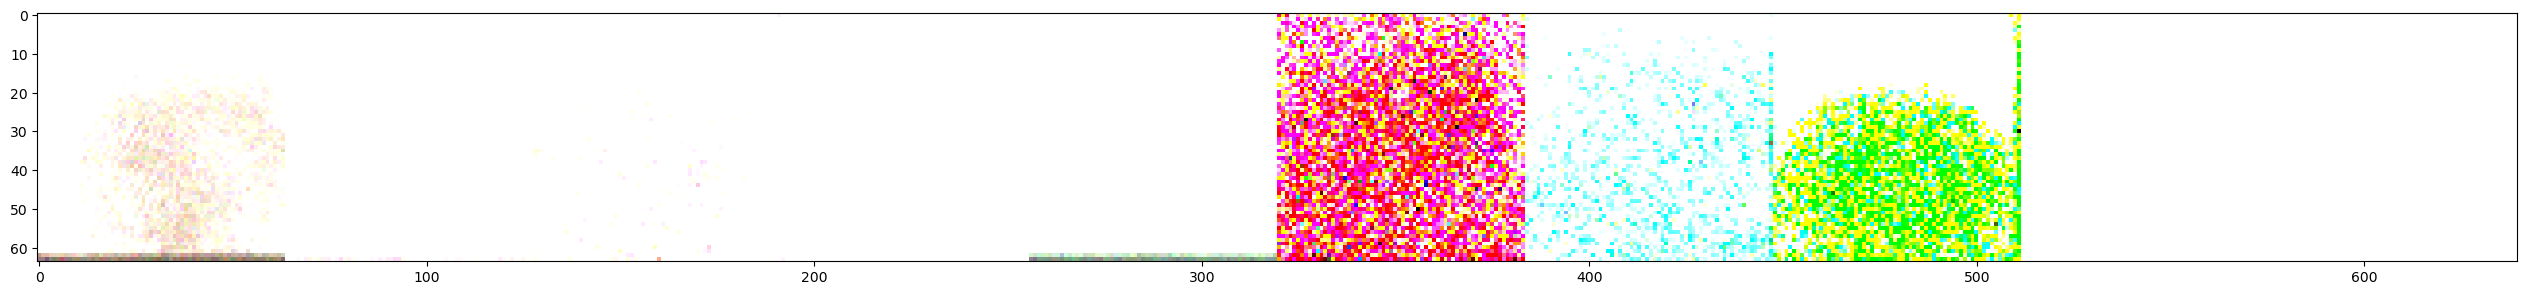

100%|██████████| 1500/1500 [02:06<00:00, 11.86it/s, MSE=0.00109] 
999it [01:51,  8.96it/s]
999it [01:51,  8.96it/s]


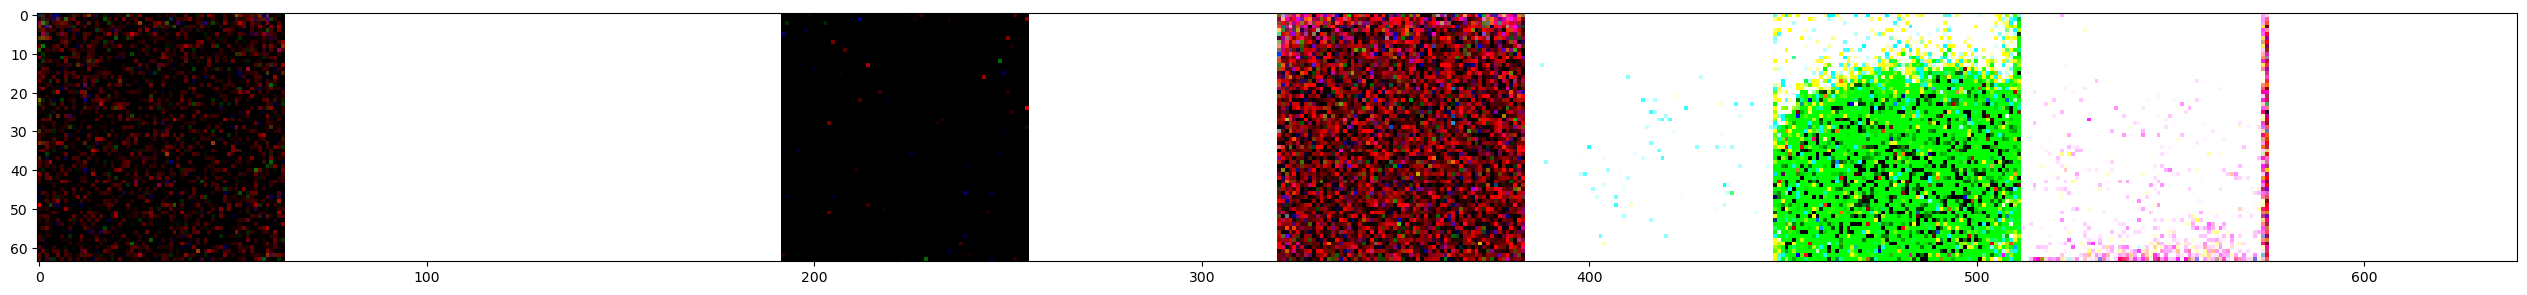

100%|██████████| 1500/1500 [02:00<00:00, 12.42it/s, MSE=0.0047]  
999it [01:54,  8.73it/s]
999it [01:53,  8.79it/s]


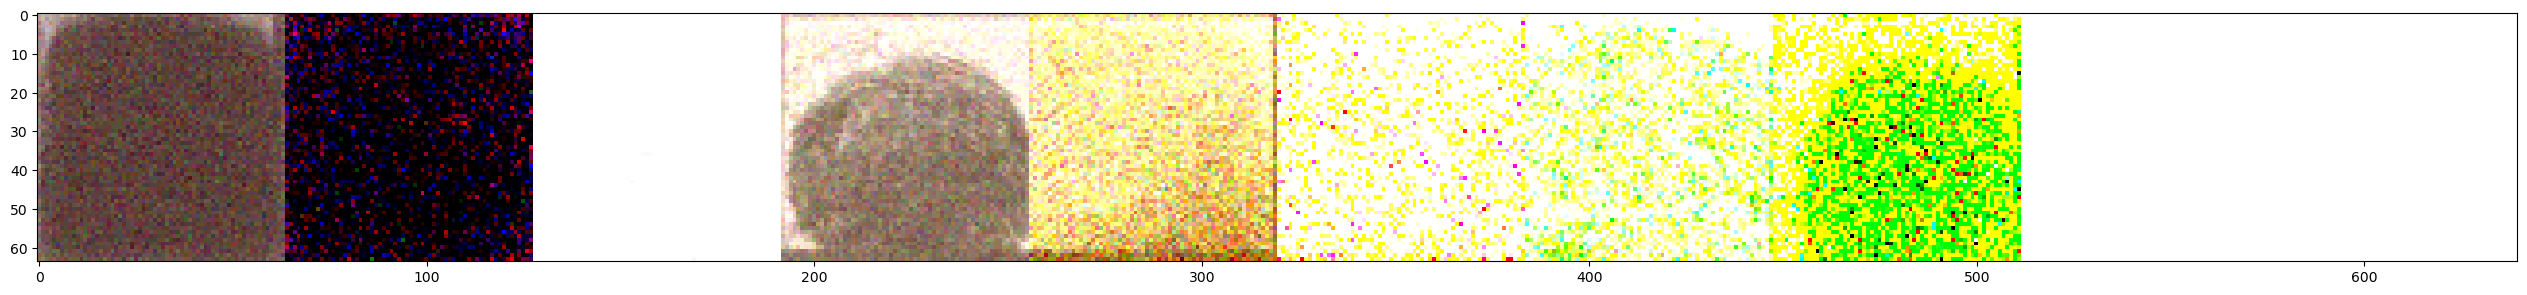

100%|██████████| 1500/1500 [02:00<00:00, 12.40it/s, MSE=0.00296] 
999it [01:45,  9.47it/s]
999it [01:46,  9.34it/s]


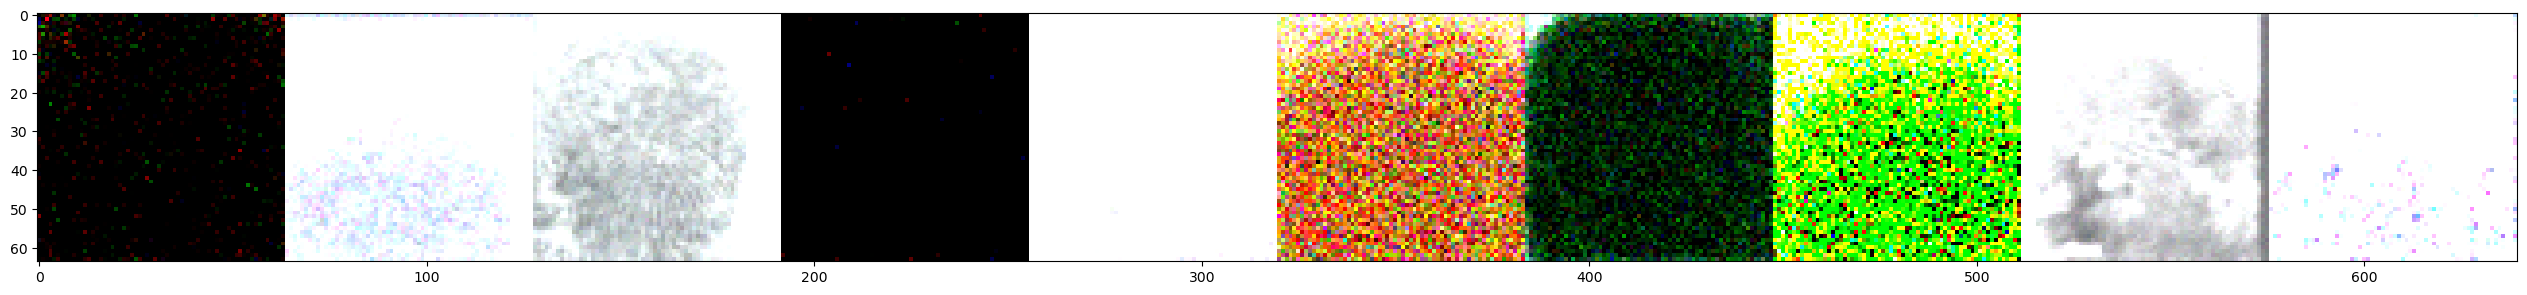

100%|██████████| 1500/1500 [02:00<00:00, 12.44it/s, MSE=0.00157] 
999it [01:50,  9.01it/s]
999it [01:54,  8.69it/s]


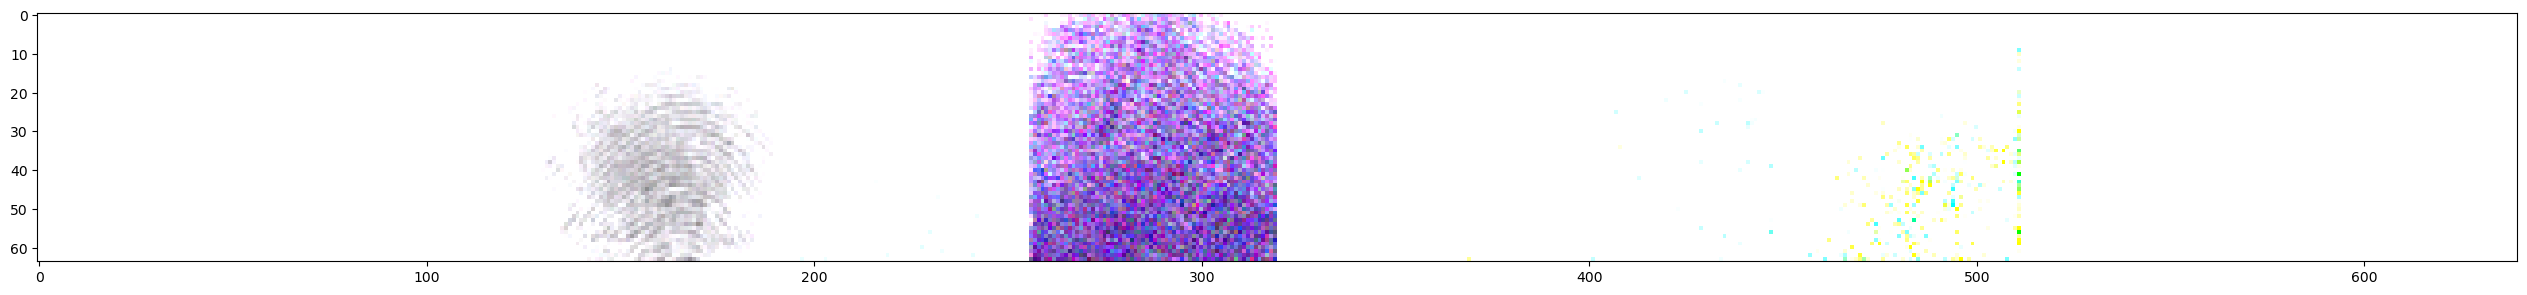

100%|██████████| 1500/1500 [02:01<00:00, 12.31it/s, MSE=0.0107]  
999it [01:49,  9.13it/s]
999it [01:49,  9.13it/s]


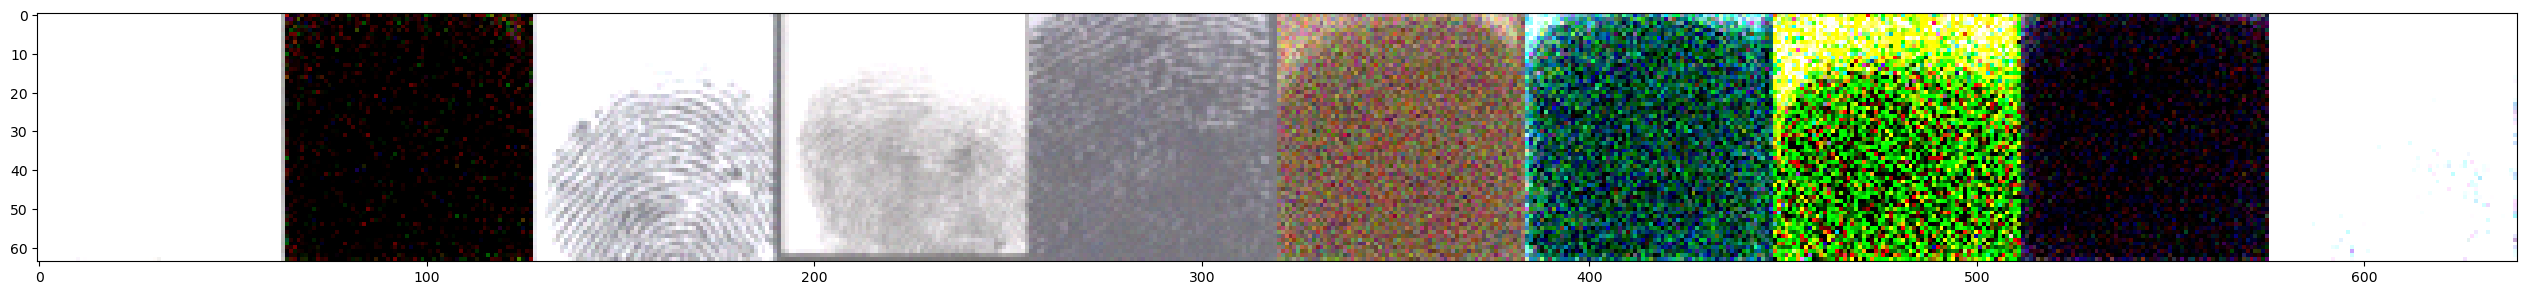

100%|██████████| 1500/1500 [02:01<00:00, 12.35it/s, MSE=0.0183]  
999it [01:51,  8.95it/s]
999it [01:53,  8.81it/s]


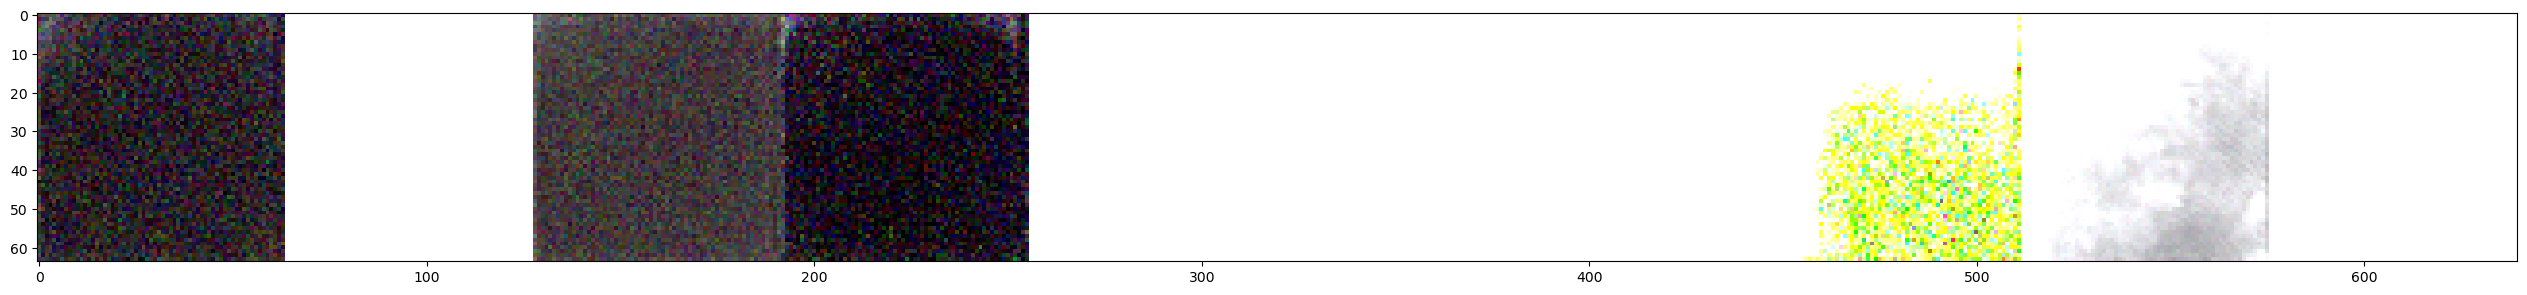

100%|██████████| 1500/1500 [01:59<00:00, 12.57it/s, MSE=0.00888] 
999it [01:51,  8.99it/s]
999it [01:53,  8.81it/s]


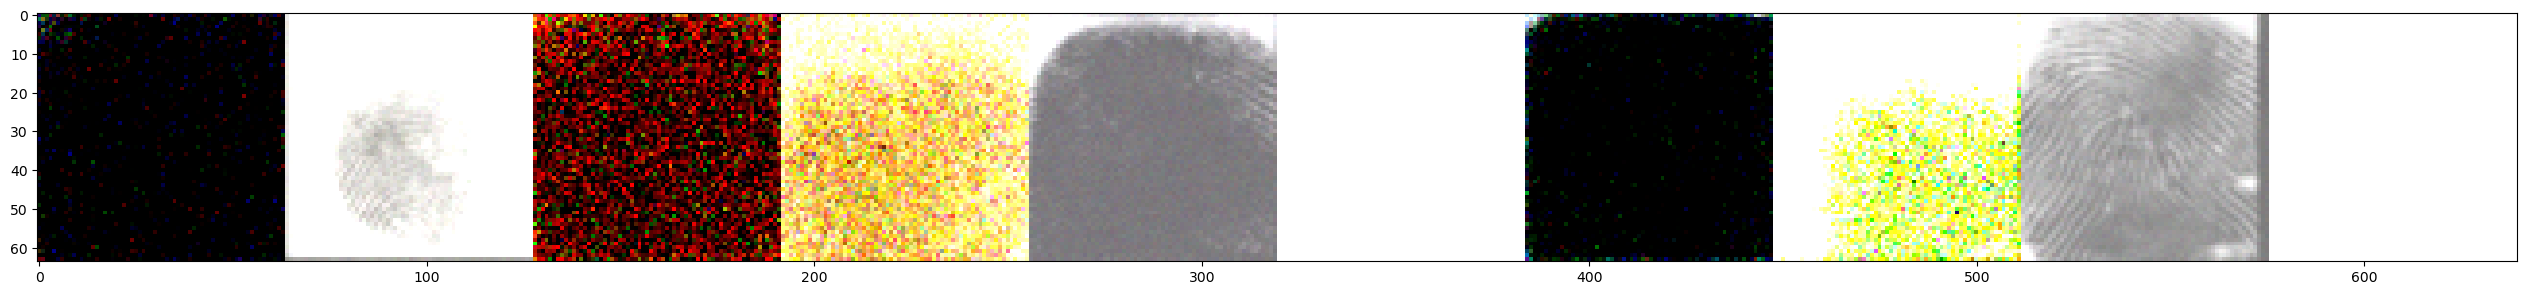

100%|██████████| 1500/1500 [01:56<00:00, 12.85it/s, MSE=0.0259]  
999it [01:43,  9.64it/s]
999it [01:49,  9.10it/s]


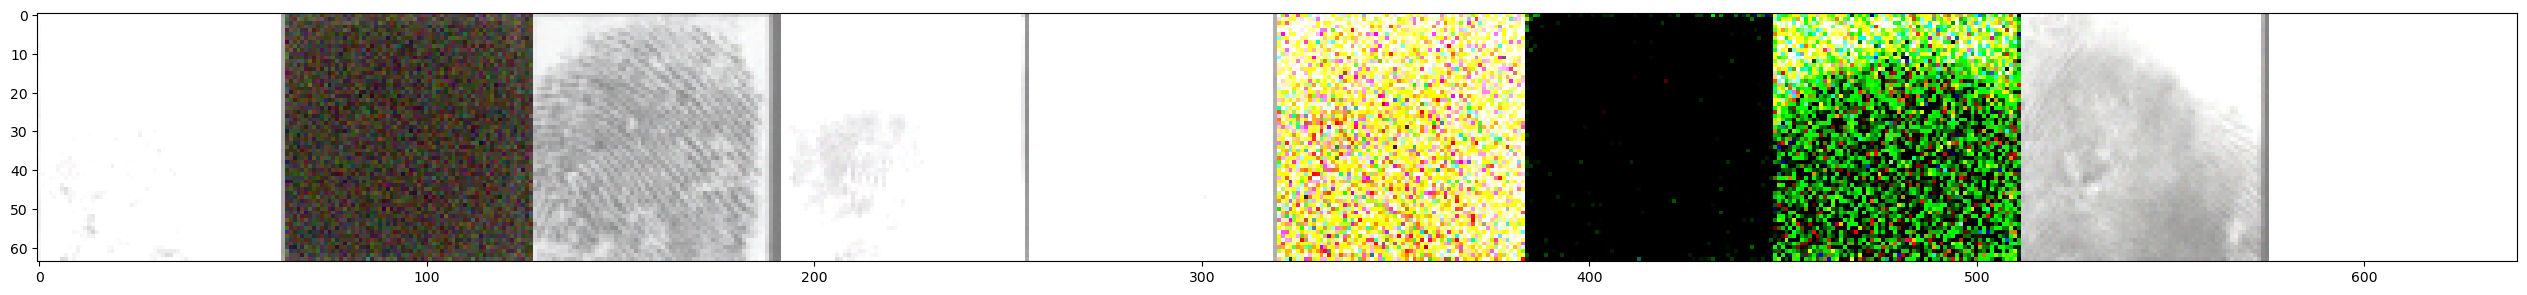

100%|██████████| 1500/1500 [01:59<00:00, 12.51it/s, MSE=0.00526] 
999it [01:45,  9.51it/s]
999it [01:46,  9.41it/s]


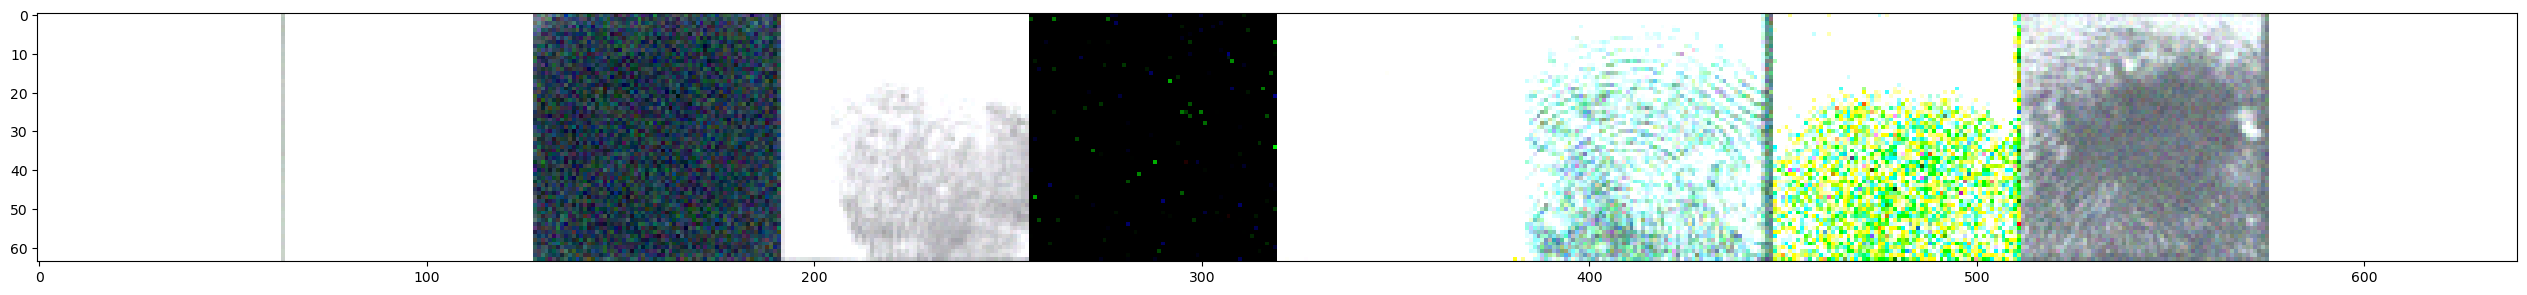

100%|██████████| 1500/1500 [01:58<00:00, 12.61it/s, MSE=0.0445]  
999it [01:45,  9.43it/s]
999it [01:44,  9.60it/s]


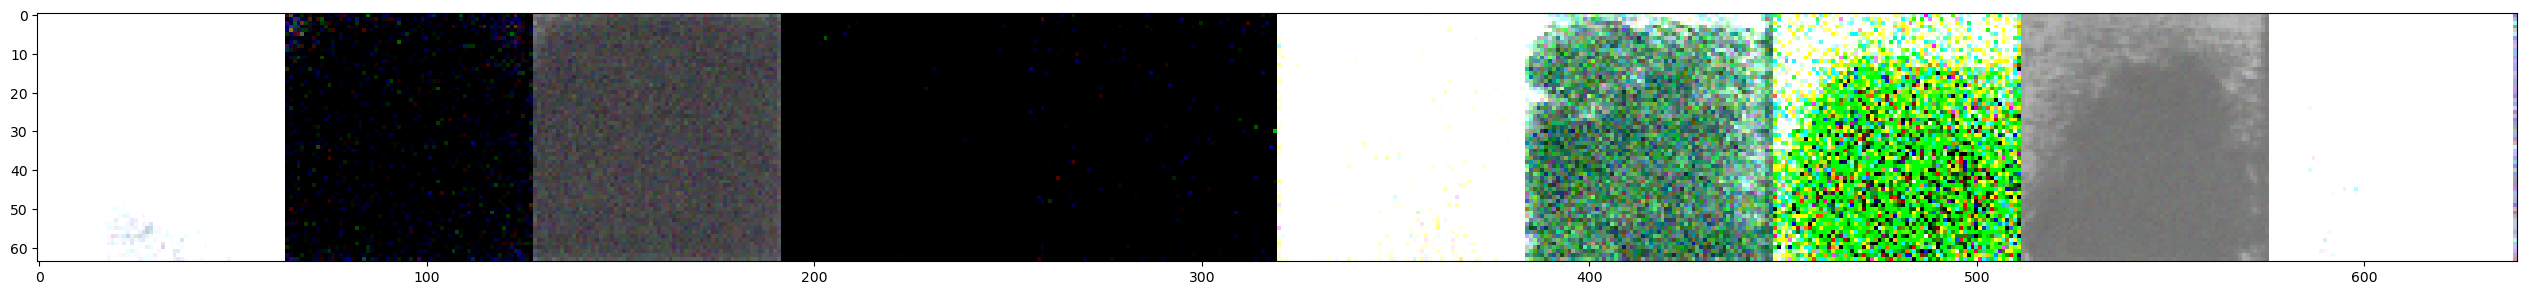

100%|██████████| 1500/1500 [01:57<00:00, 12.79it/s, MSE=0.0117]  
999it [01:45,  9.45it/s]
999it [01:44,  9.60it/s]


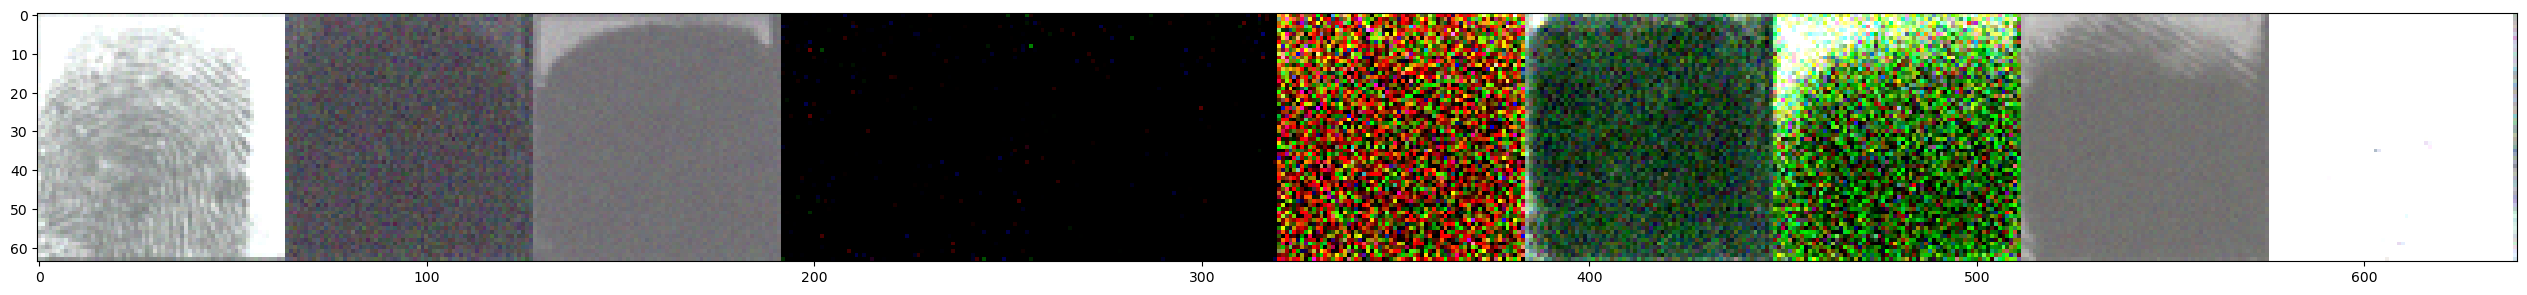

100%|██████████| 1500/1500 [01:54<00:00, 13.05it/s, MSE=0.0101]  
999it [01:44,  9.59it/s]
999it [01:50,  9.04it/s]


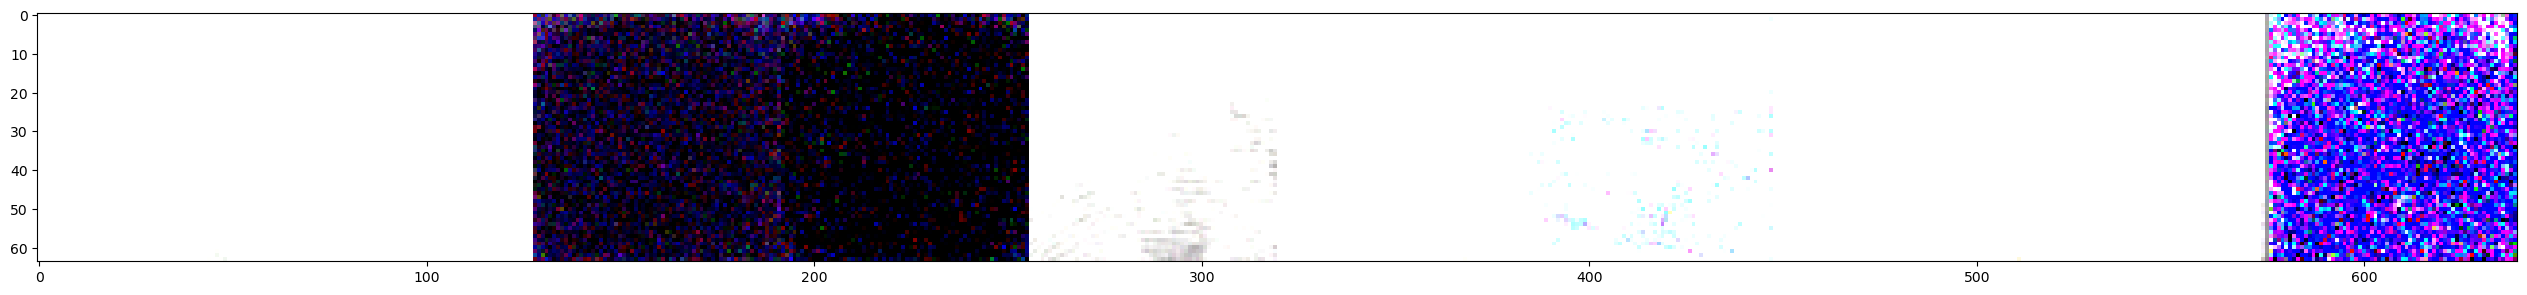

100%|██████████| 1500/1500 [02:00<00:00, 12.50it/s, MSE=0.00806] 
999it [01:48,  9.17it/s]
999it [01:48,  9.19it/s]


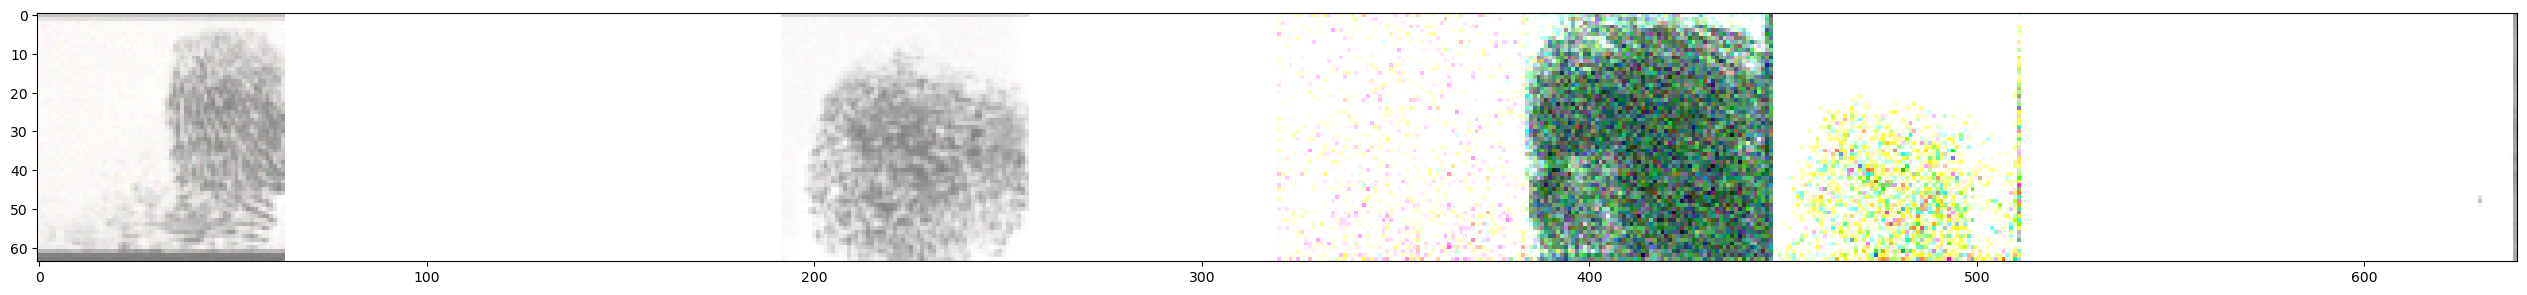

100%|██████████| 1500/1500 [01:54<00:00, 13.04it/s, MSE=0.00792] 
999it [01:48,  9.17it/s]
999it [01:48,  9.20it/s]


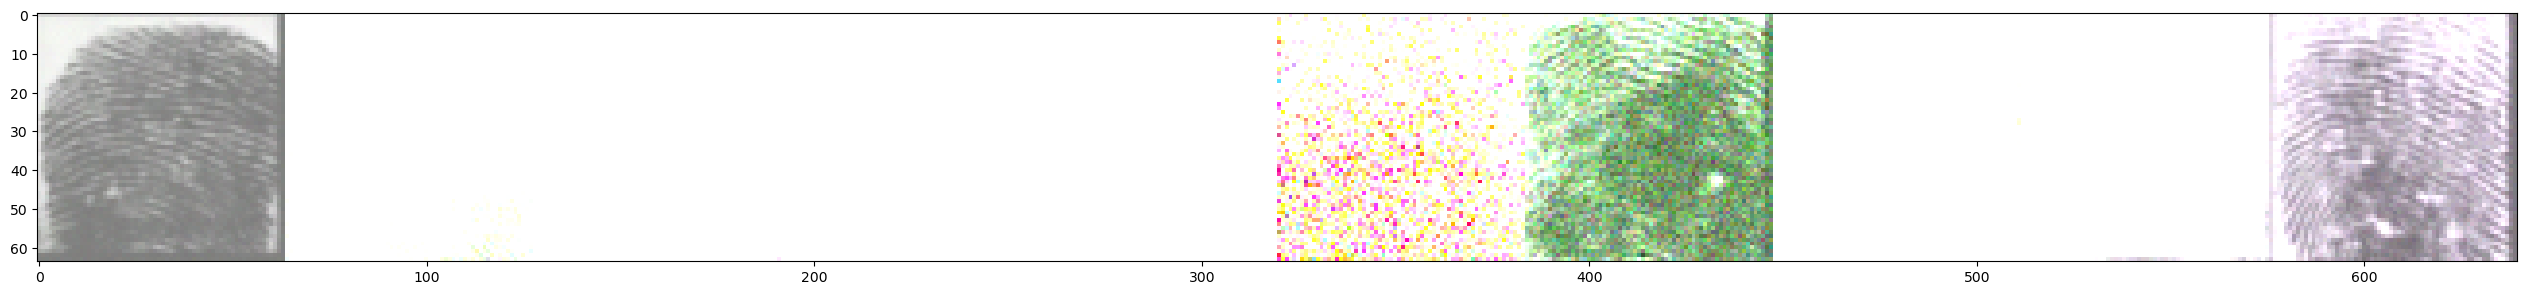

100%|██████████| 1500/1500 [01:58<00:00, 12.66it/s, MSE=0.0018]  
999it [01:54,  8.73it/s]
999it [01:50,  9.04it/s]


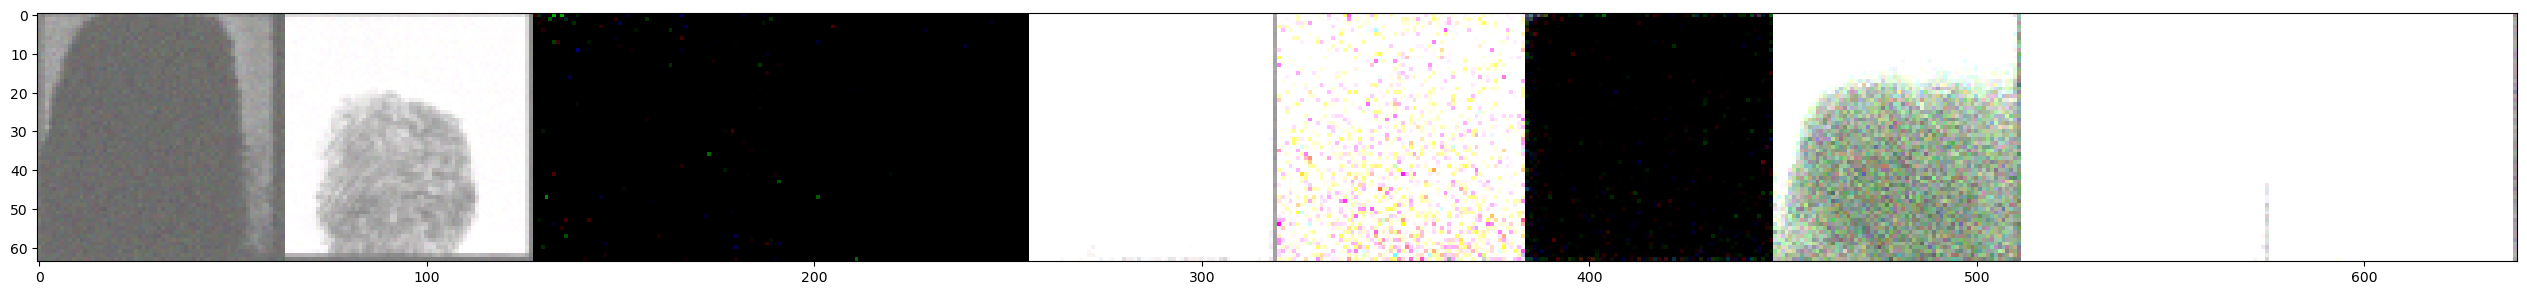

100%|██████████| 1500/1500 [01:59<00:00, 12.57it/s, MSE=0.00376] 
999it [01:51,  8.94it/s]
999it [01:49,  9.10it/s]


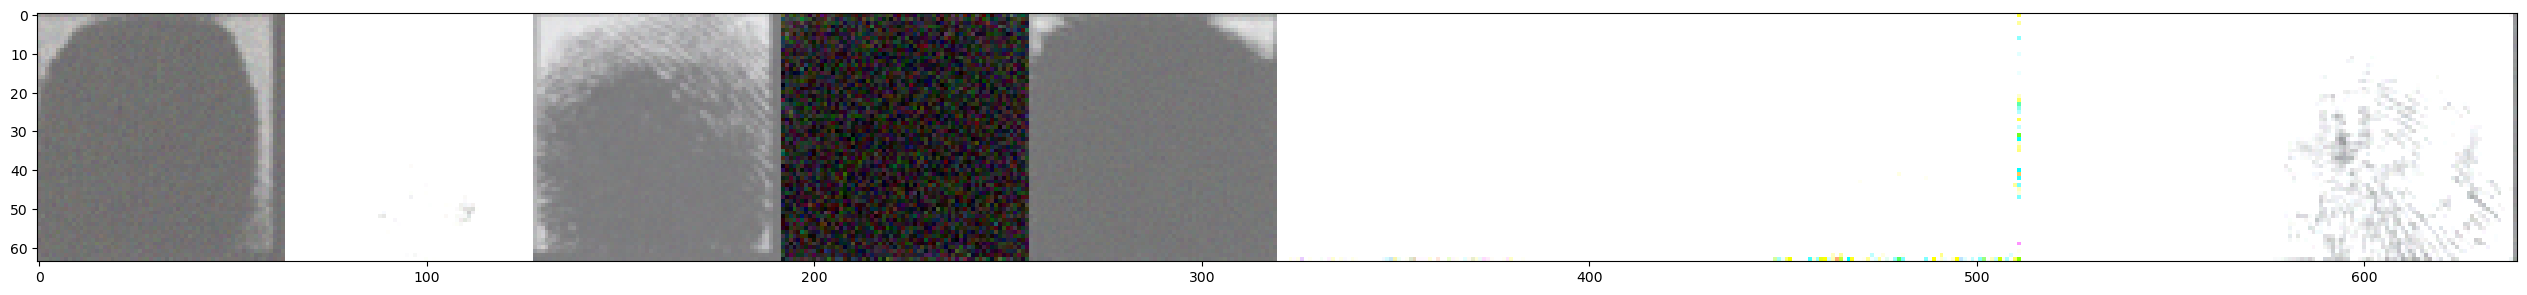

100%|██████████| 1500/1500 [01:58<00:00, 12.70it/s, MSE=0.00329] 
999it [01:44,  9.52it/s]
999it [01:51,  8.95it/s]


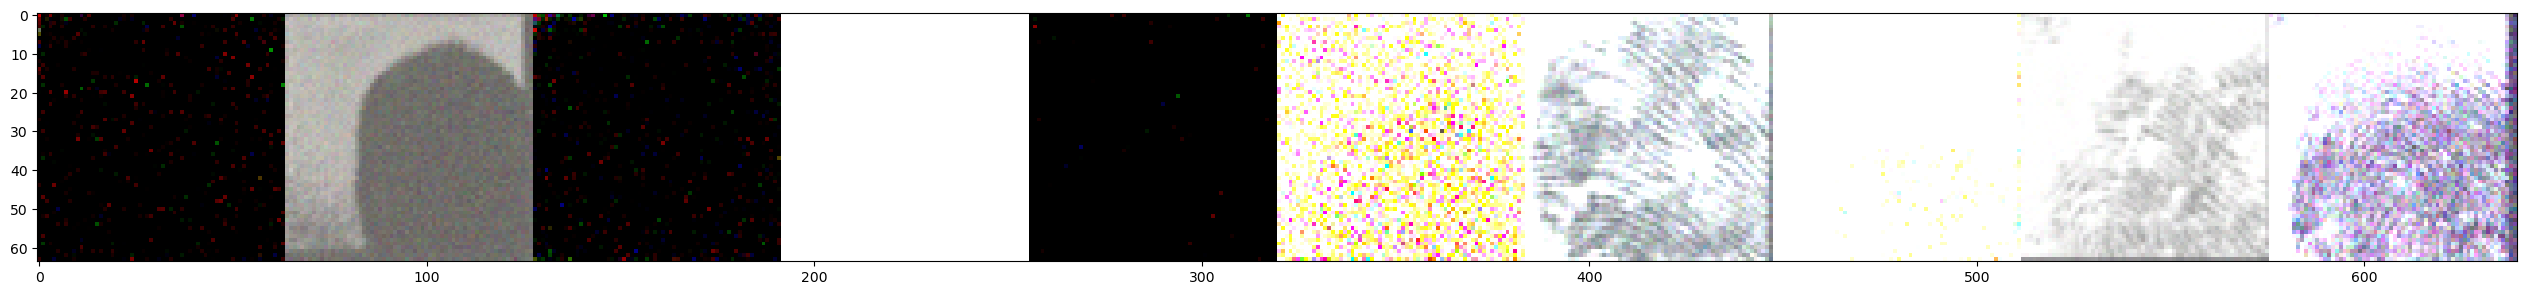

100%|██████████| 1500/1500 [01:59<00:00, 12.60it/s, MSE=0.0339]  
999it [01:52,  8.88it/s]
999it [01:50,  9.02it/s]


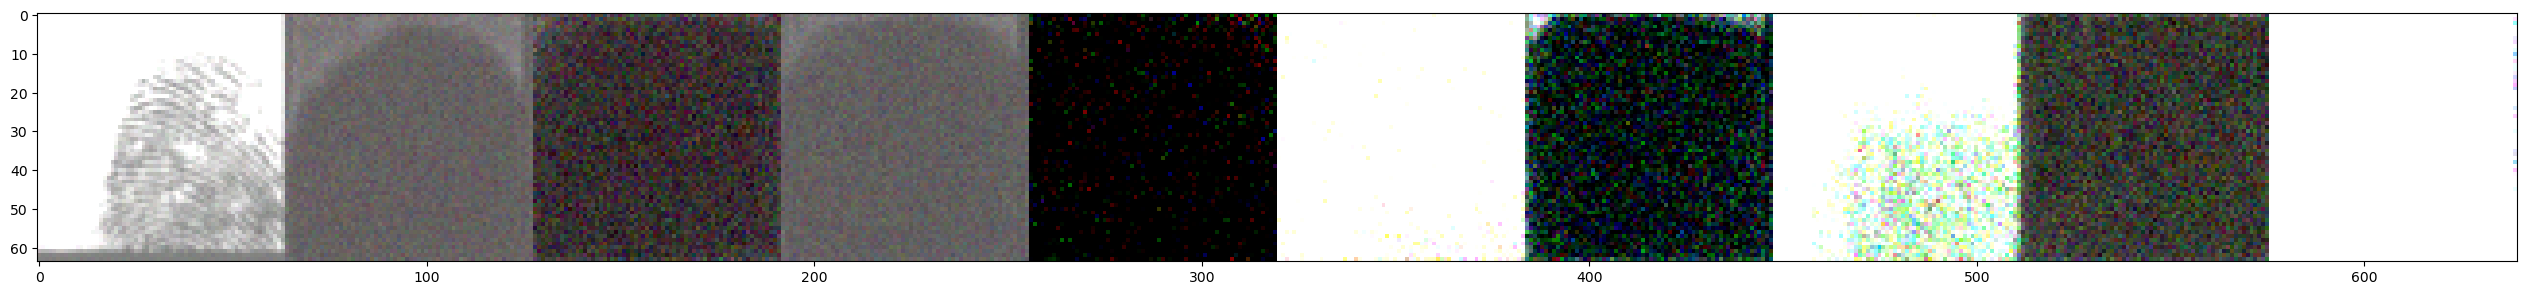

100%|██████████| 1500/1500 [02:04<00:00, 12.07it/s, MSE=0.014]   
999it [01:55,  8.62it/s]
999it [01:48,  9.21it/s]


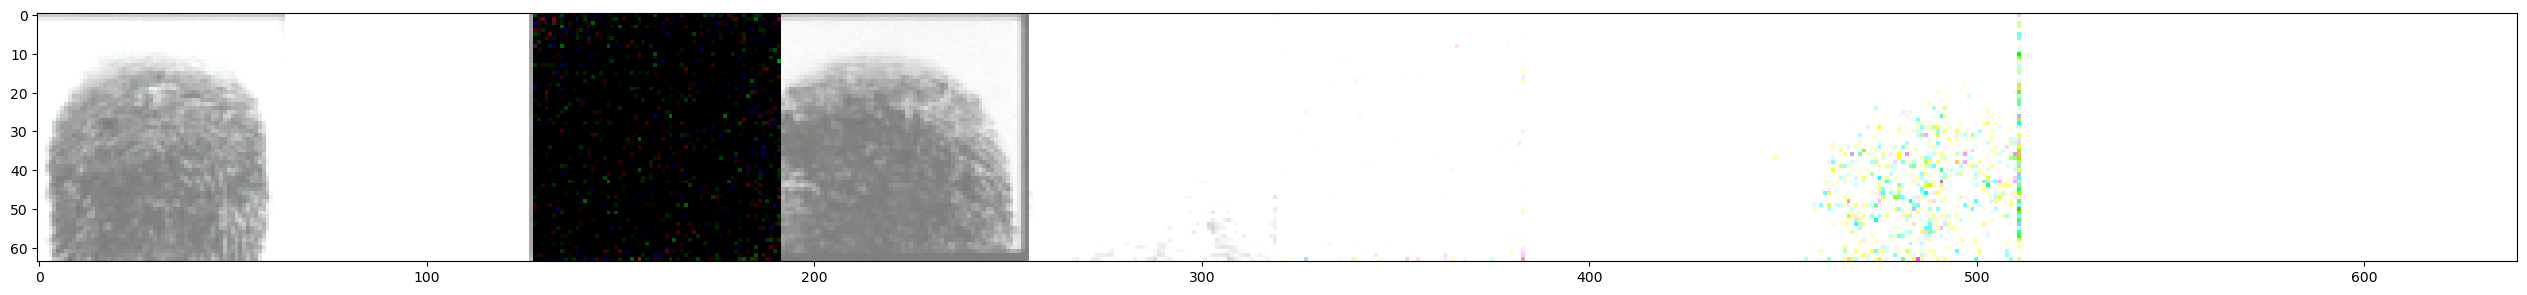

100%|██████████| 1500/1500 [01:59<00:00, 12.53it/s, MSE=0.00355] 
999it [01:47,  9.26it/s]
999it [01:48,  9.21it/s]


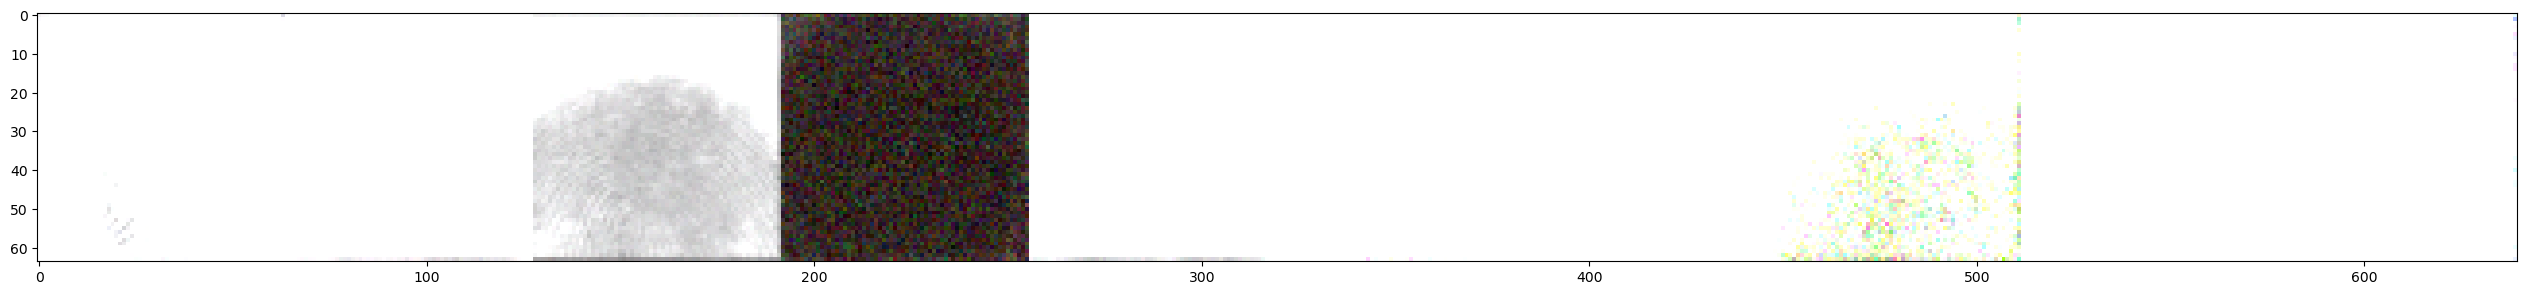

100%|██████████| 1500/1500 [02:00<00:00, 12.45it/s, MSE=0.00243] 
999it [01:48,  9.18it/s]
999it [01:48,  9.18it/s]


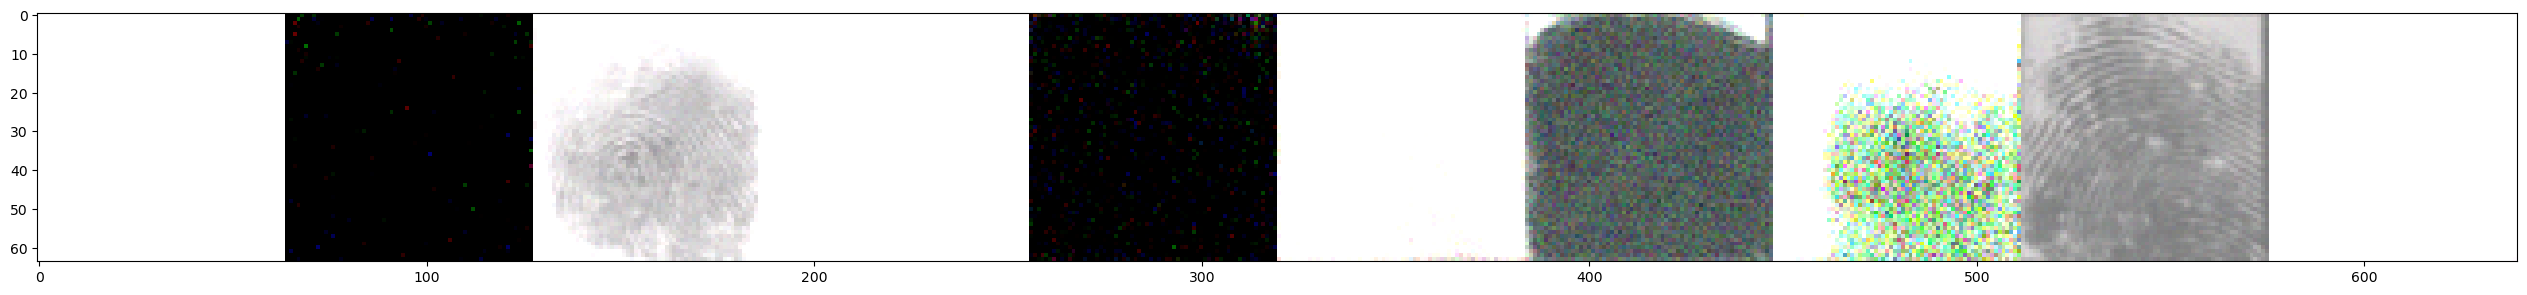

100%|██████████| 1500/1500 [02:00<00:00, 12.45it/s, MSE=0.052]   
999it [01:48,  9.20it/s]
999it [01:48,  9.19it/s]


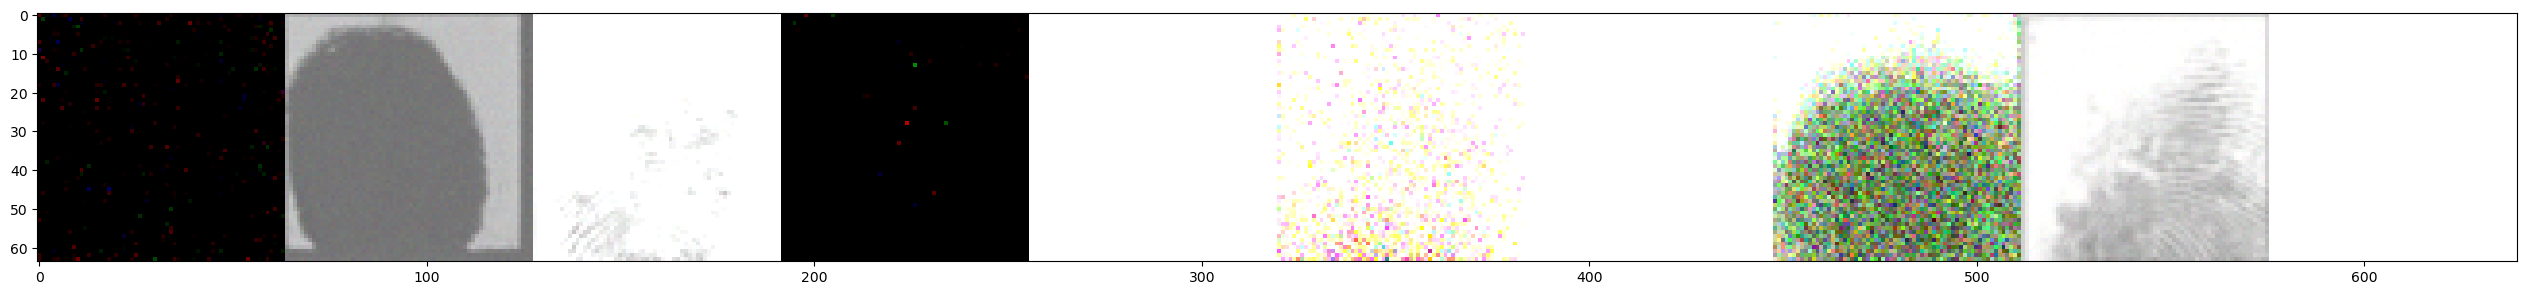

100%|██████████| 1500/1500 [01:59<00:00, 12.53it/s, MSE=0.00118] 
999it [01:48,  9.17it/s]
999it [01:49,  9.16it/s]


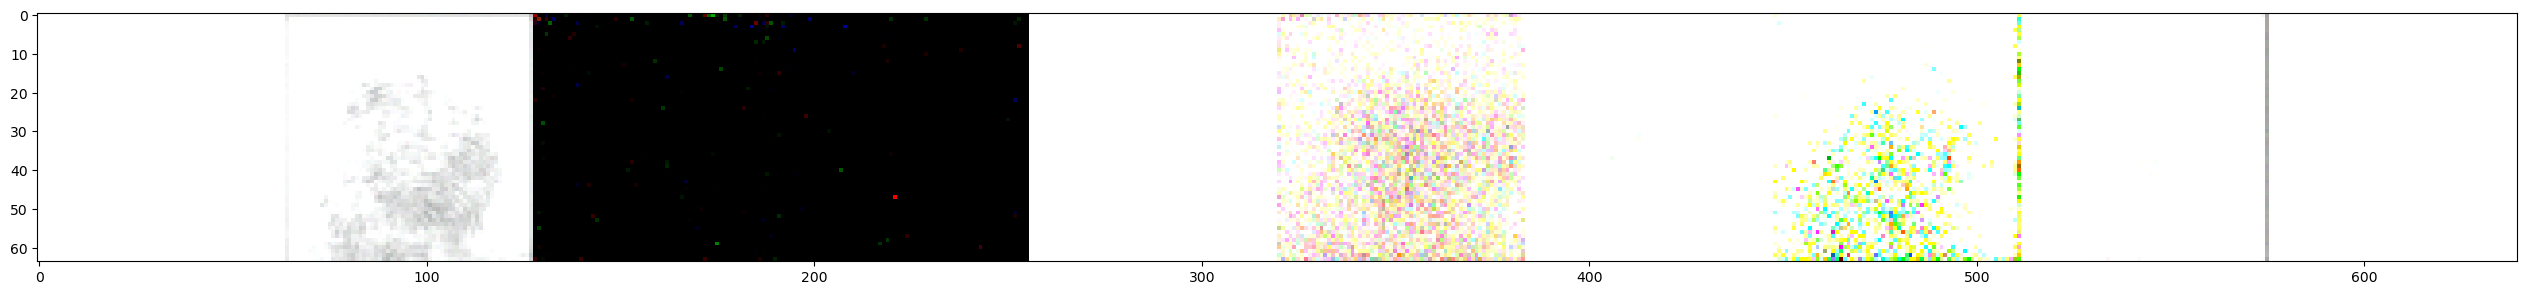

100%|██████████| 1500/1500 [01:59<00:00, 12.50it/s, MSE=0.00727] 
999it [01:48,  9.18it/s]
999it [01:48,  9.19it/s]


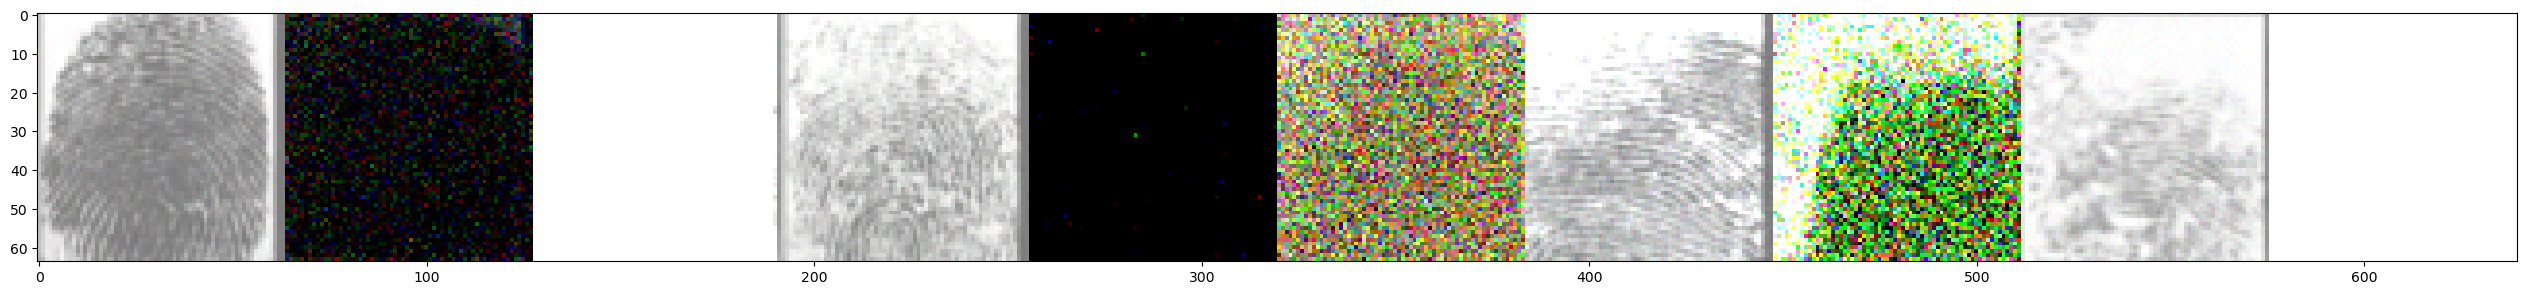

100%|██████████| 1500/1500 [02:00<00:00, 12.47it/s, MSE=0.00641] 
999it [01:49,  9.16it/s]
999it [01:48,  9.18it/s]


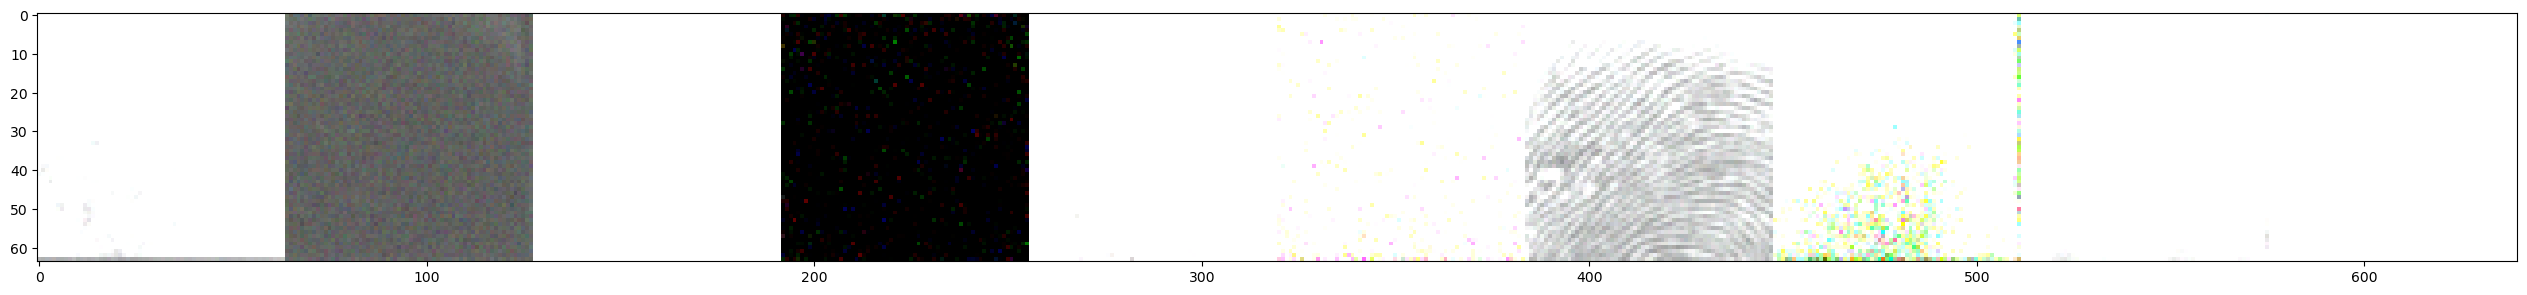

In [37]:
train()

In [27]:
#clear GPU cache
# torch.cuda.empty_cache()

In [28]:
torch.cuda.memory_allocated() 

17039360

In [38]:
run_name = "DDPM_conditional"
epochs = 30
batch_size = 4
image_size = 64
num_classes = 10
dataset_path = dataset_path
device = device
lr = 3e-4

In [41]:
def train():
    setup_logging(run_name)
    # dataloader = get_data(
    model = UNet_conditional(num_classes=num_classes).to(device)
    ckpt = torch.load("models/DDPM_conditional/ckpt.pt")
    model.load_state_dict(ckpt)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=image_size, device=device)
    logger = SummaryWriter(os.path.join("runs", run_name))
    l = len(dataloader)
    ema = EMA(0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)

    for epoch in range(epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            if np.random.random() < 0.1:
                labels = None
            # with autocast(dtype=torch.float16):
            predicted_noise = model(x_t, t, labels)
            noise = noise.float()
            predicted_noise = predicted_noise.float()
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.step_ema(ema_model, model)

            pbar.set_postfix(MSE=loss.item())
            logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

        if epoch % 1 == 0:
            labels = torch.arange(10).long().to(device)
            sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
            ema_sampled_images = diffusion.sample(ema_model, n=len(labels), labels=labels)
            plot_images(sampled_images)
            save_images(sampled_images, os.path.join("results", run_name, f"{epoch+80}.jpg"))
            save_images(ema_sampled_images, os.path.join("results", run_name, f"{epoch+80}_ema.jpg"))
            torch.save(model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
            torch.save(ema_model.state_dict(), os.path.join("models", run_name, f"ema_ckpt.pt"))
            torch.save(optimizer.state_dict(), os.path.join("models", run_name, f"optim.pt"))

100%|██████████| 1500/1500 [01:55<00:00, 12.99it/s, MSE=0.0117]  
999it [01:46,  9.42it/s]
999it [01:46,  9.41it/s]


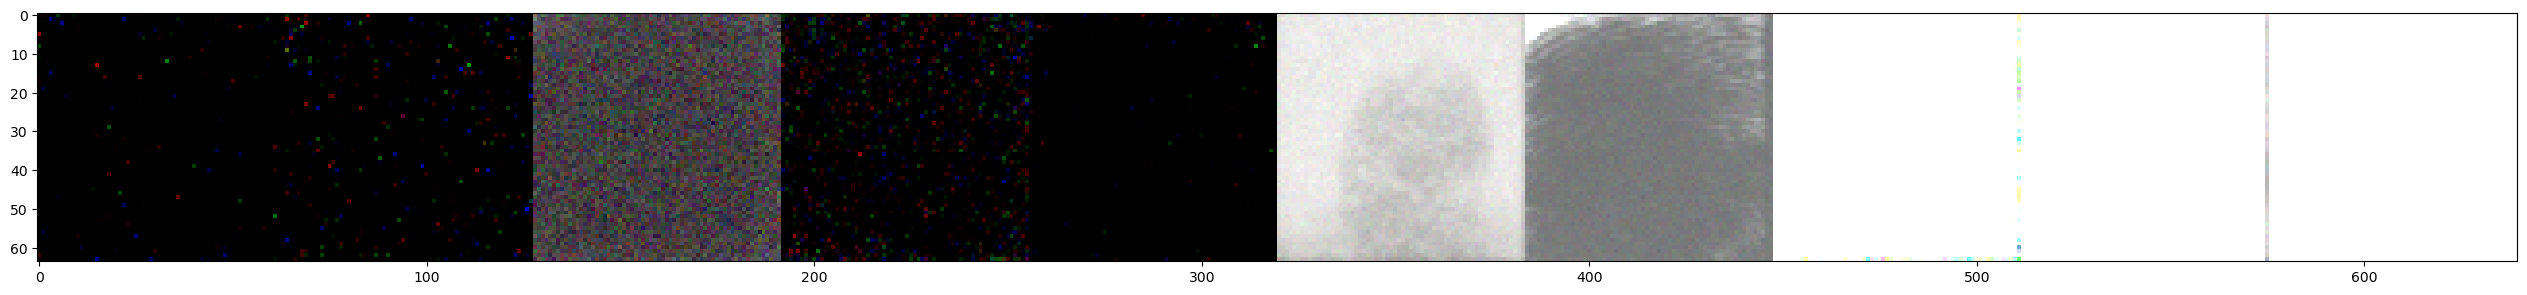

100%|██████████| 1500/1500 [01:56<00:00, 12.92it/s, MSE=0.000602]
999it [01:46,  9.40it/s]
999it [01:46,  9.40it/s]


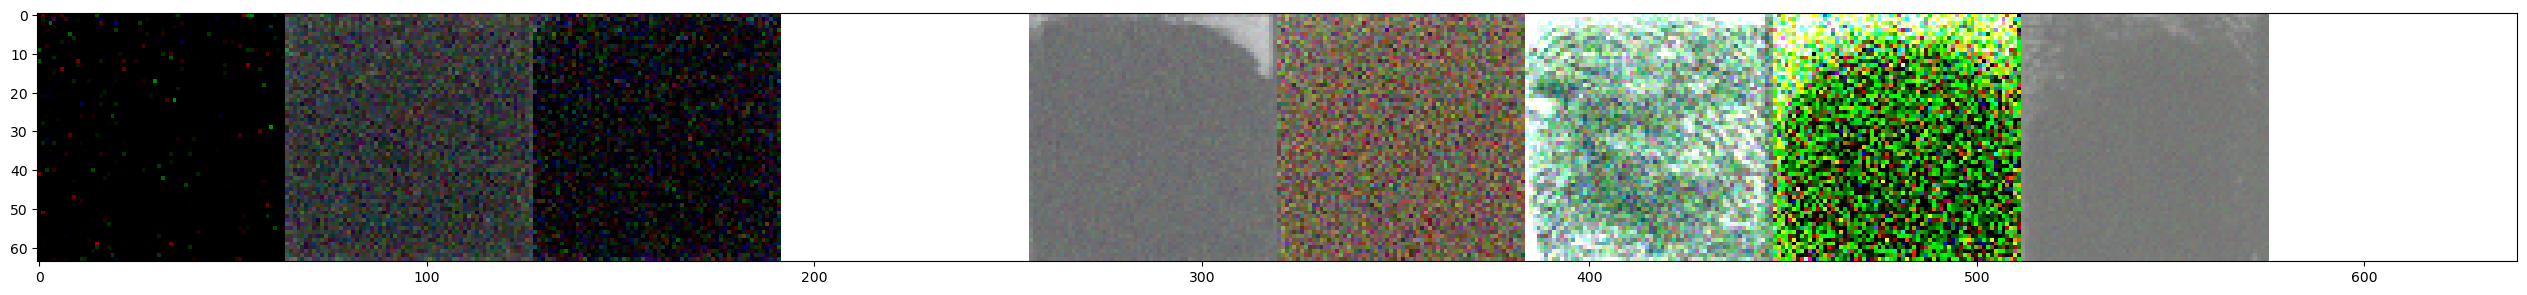

100%|██████████| 1500/1500 [01:57<00:00, 12.82it/s, MSE=0.0039]  
999it [01:46,  9.42it/s]
999it [01:46,  9.39it/s]


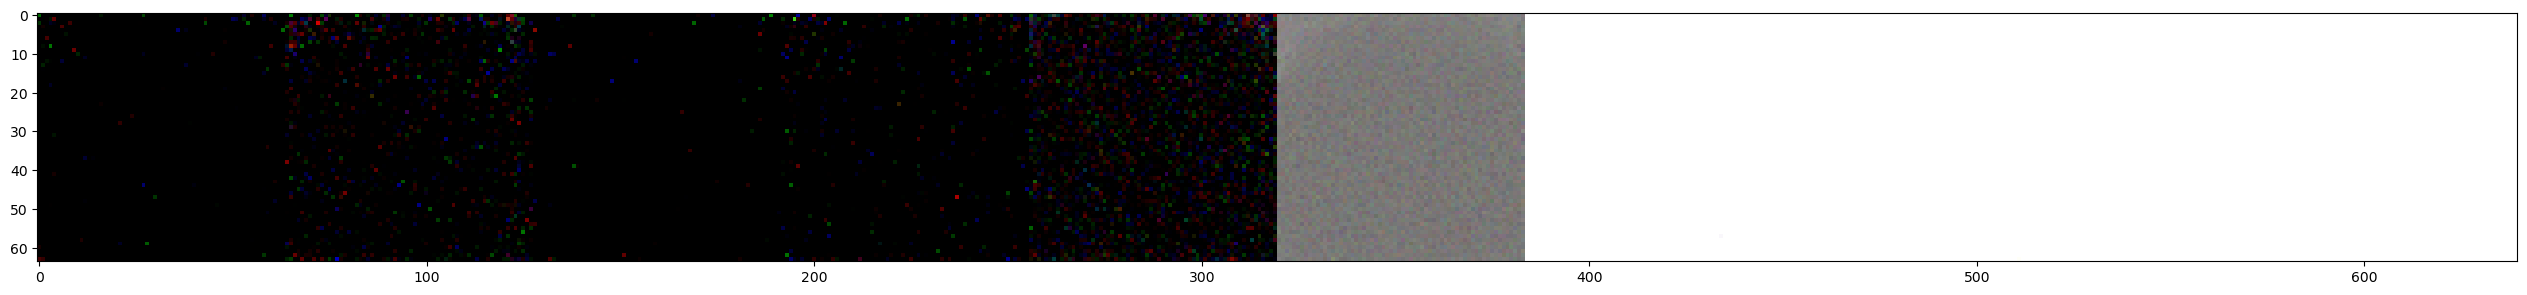

100%|██████████| 1500/1500 [01:56<00:00, 12.85it/s, MSE=0.0159]  
999it [01:46,  9.41it/s]
999it [01:46,  9.38it/s]


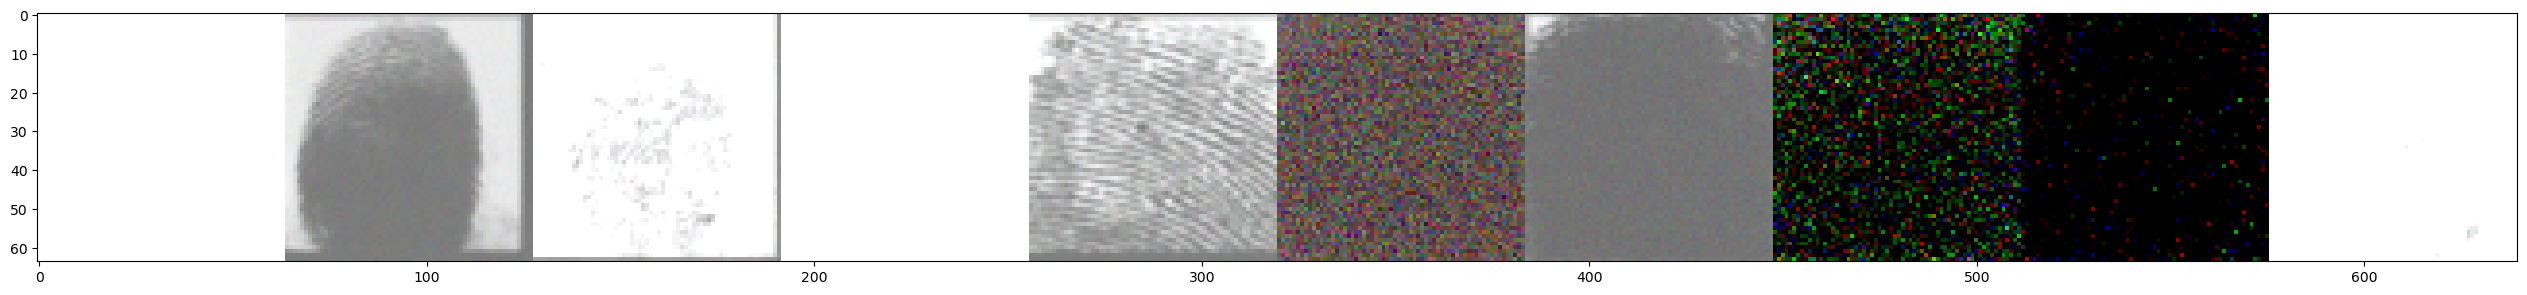

100%|██████████| 1500/1500 [01:56<00:00, 12.93it/s, MSE=0.000424]
999it [01:46,  9.42it/s]
999it [01:46,  9.40it/s]


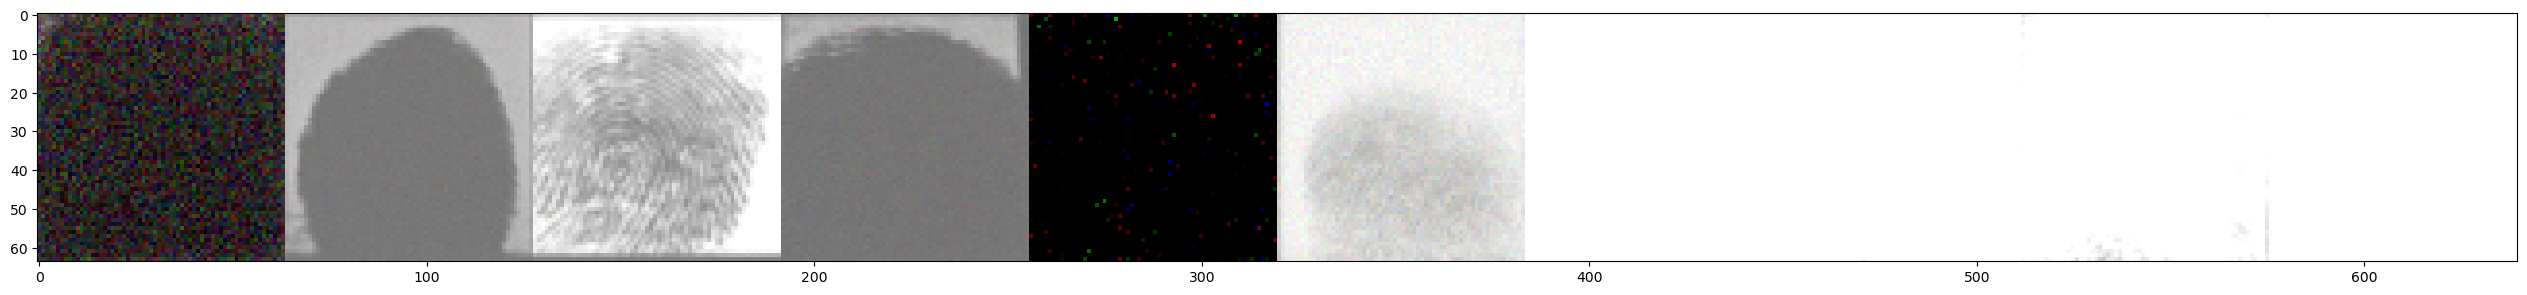

100%|██████████| 1500/1500 [01:57<00:00, 12.82it/s, MSE=0.000491]
999it [01:45,  9.43it/s]
999it [01:46,  9.41it/s]


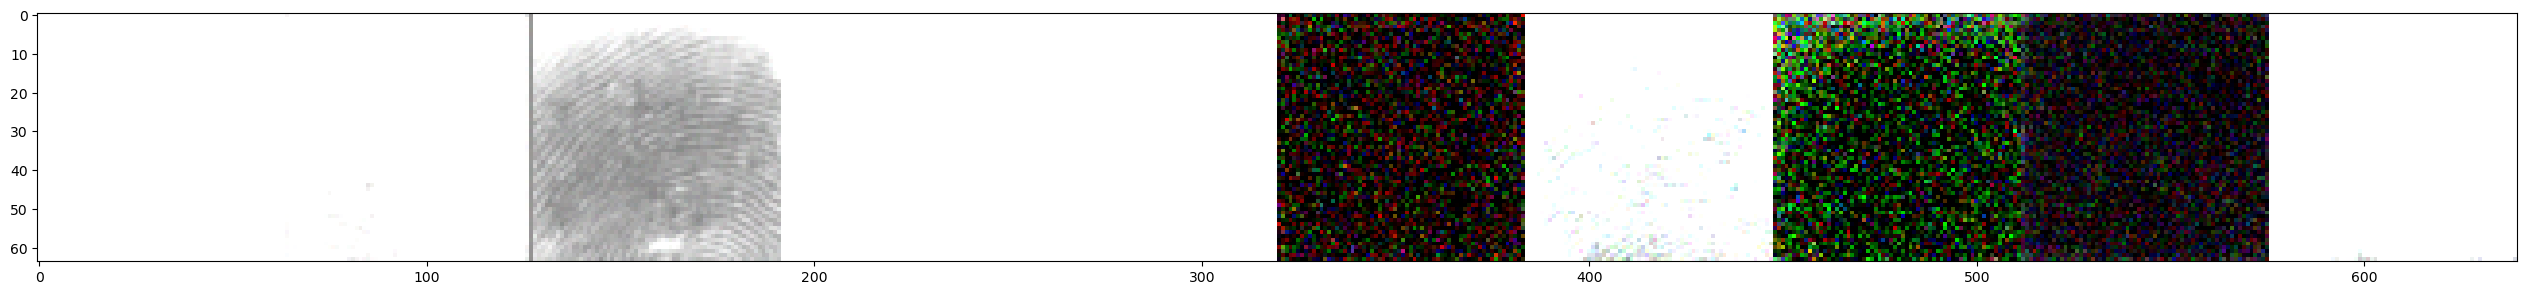

100%|██████████| 1500/1500 [01:57<00:00, 12.81it/s, MSE=0.0149]  
999it [01:46,  9.41it/s]
999it [01:46,  9.41it/s]


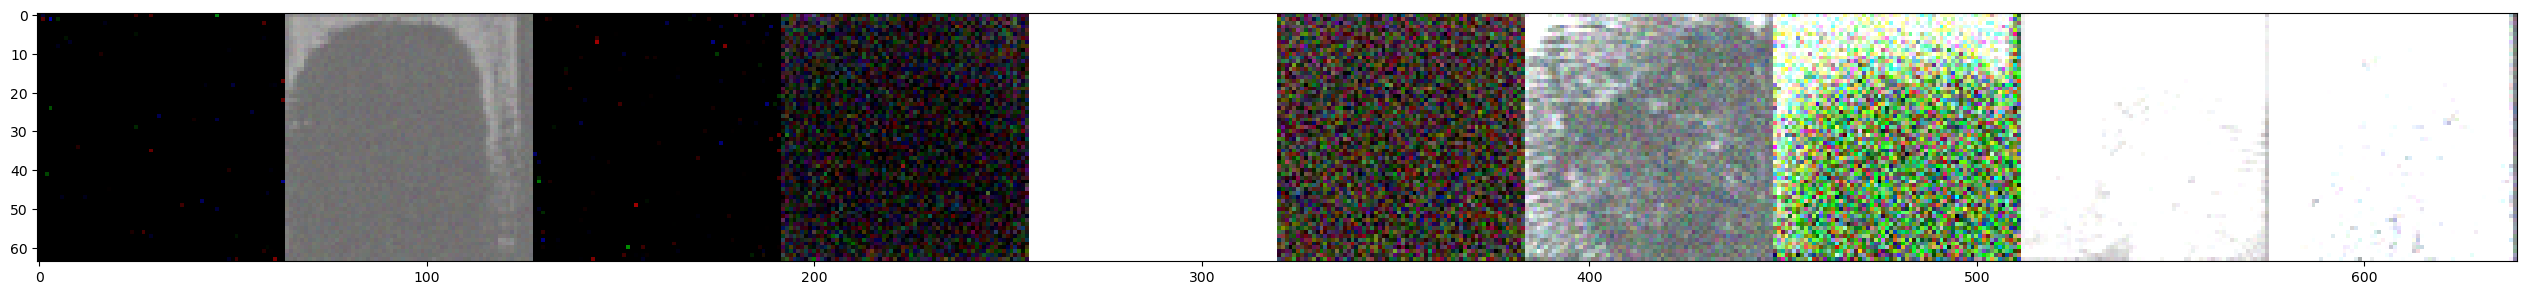

100%|██████████| 1500/1500 [01:56<00:00, 12.91it/s, MSE=0.00156] 
999it [01:46,  9.41it/s]
999it [01:46,  9.41it/s]


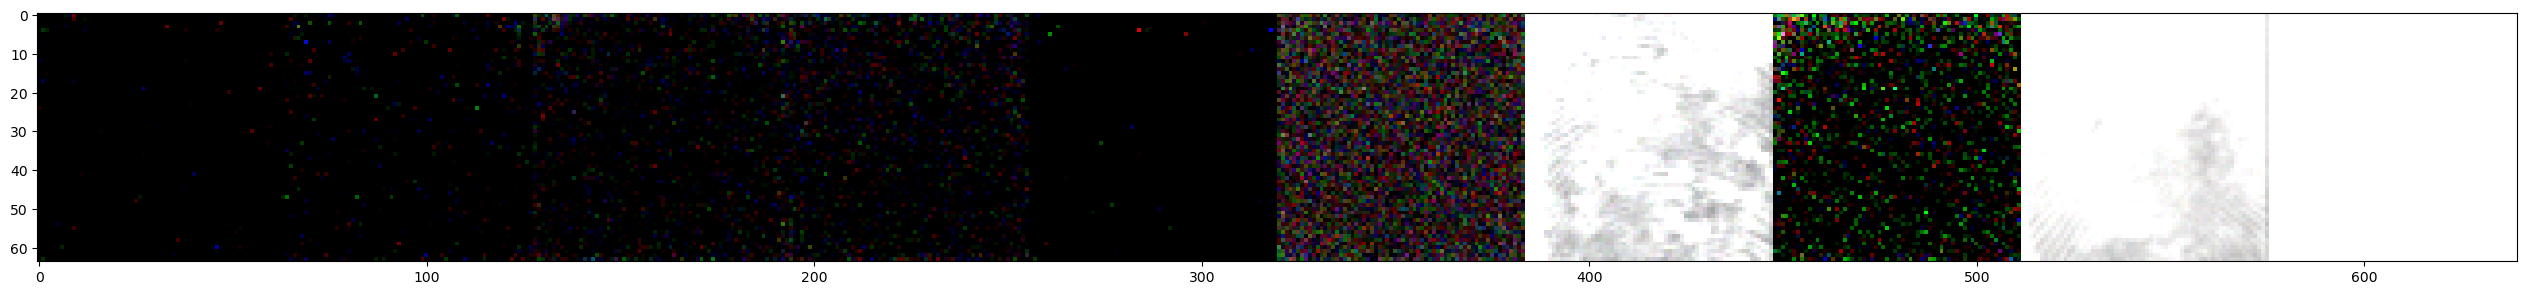

100%|██████████| 1500/1500 [01:56<00:00, 12.84it/s, MSE=0.00171] 
999it [01:46,  9.41it/s]
999it [01:46,  9.40it/s]


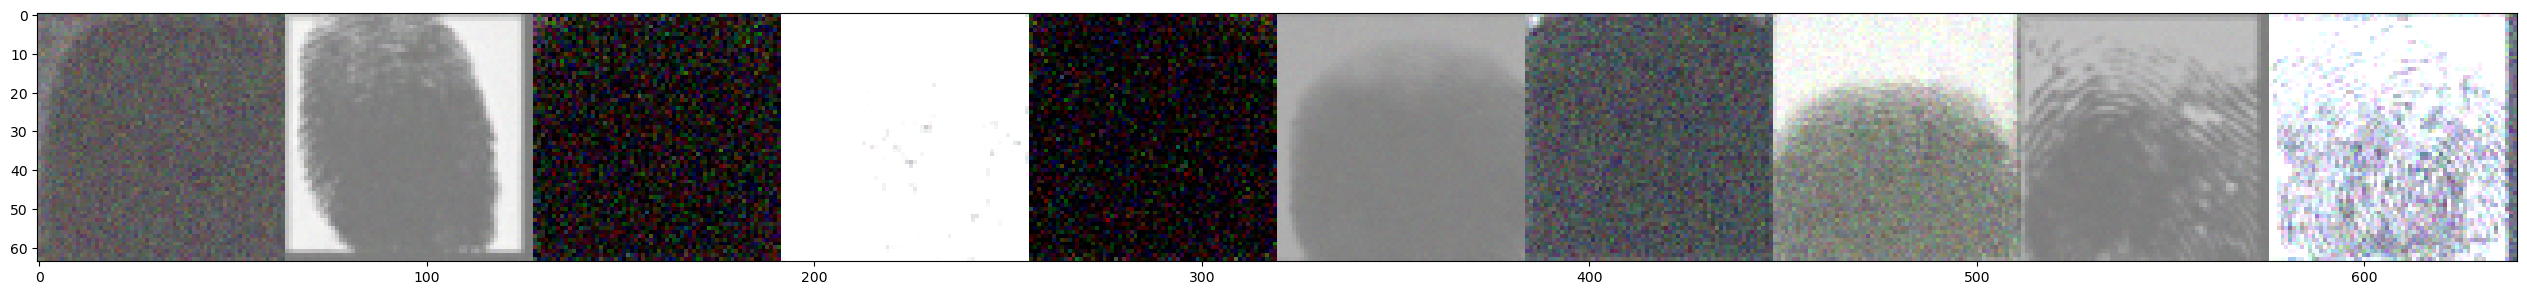

100%|██████████| 1500/1500 [01:56<00:00, 12.92it/s, MSE=0.0113]  
999it [01:46,  9.42it/s]
999it [01:46,  9.40it/s]


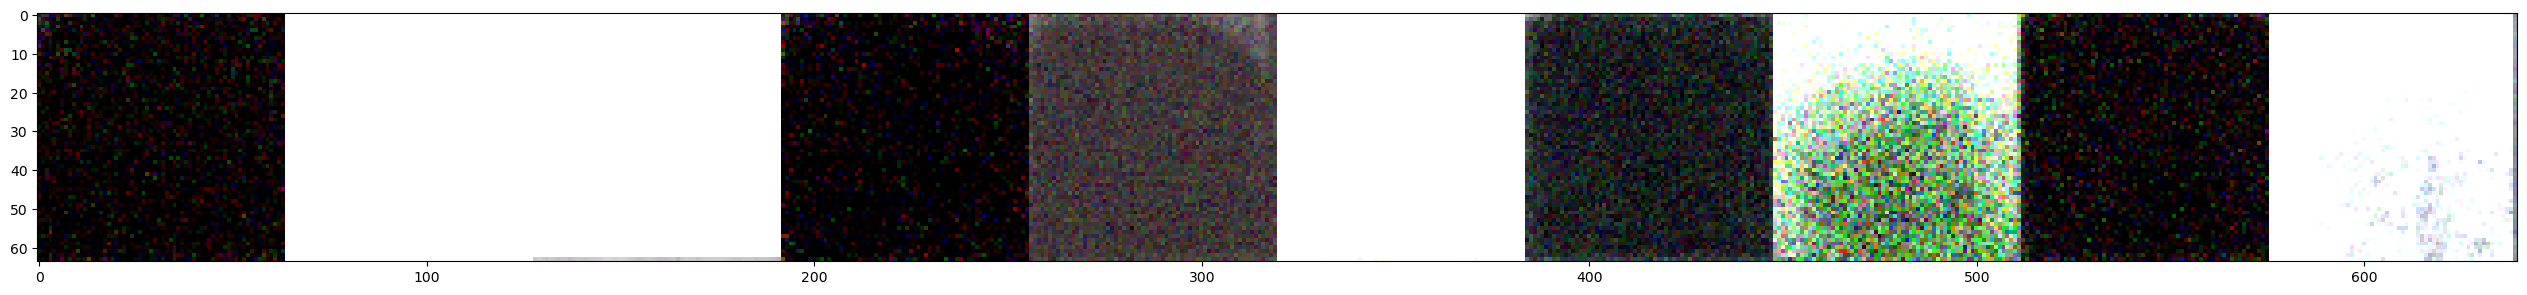

100%|██████████| 1500/1500 [01:55<00:00, 12.96it/s, MSE=0.000346]
999it [01:46,  9.42it/s]
999it [01:46,  9.41it/s]


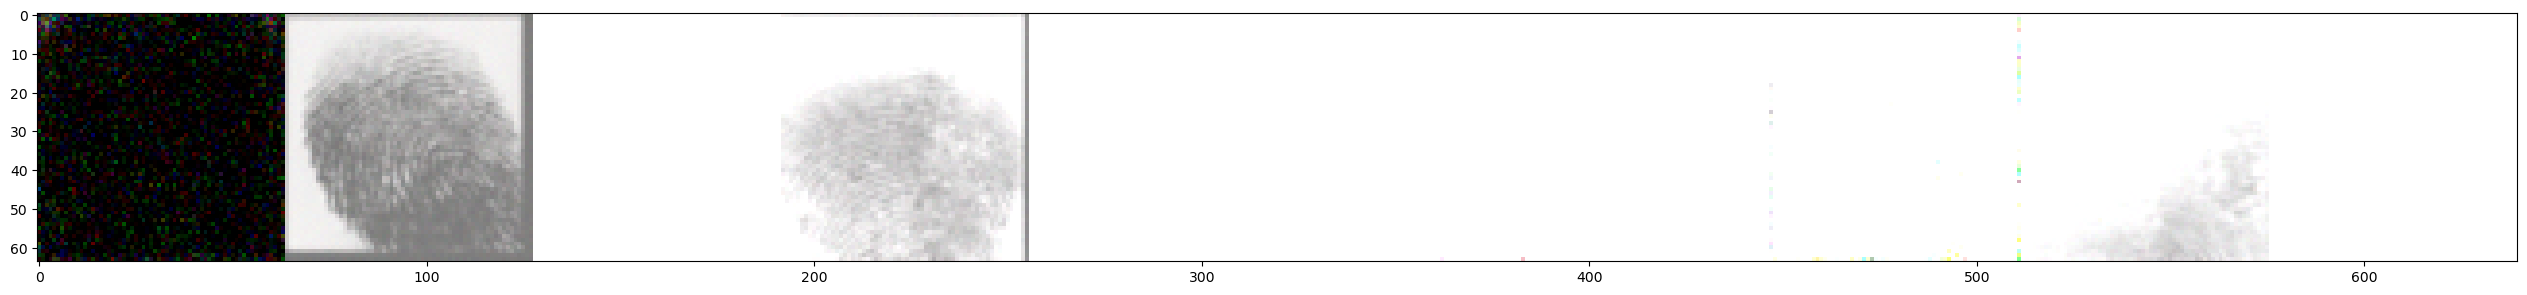

100%|██████████| 1500/1500 [01:56<00:00, 12.84it/s, MSE=0.0138]  
999it [01:46,  9.40it/s]
999it [01:46,  9.40it/s]


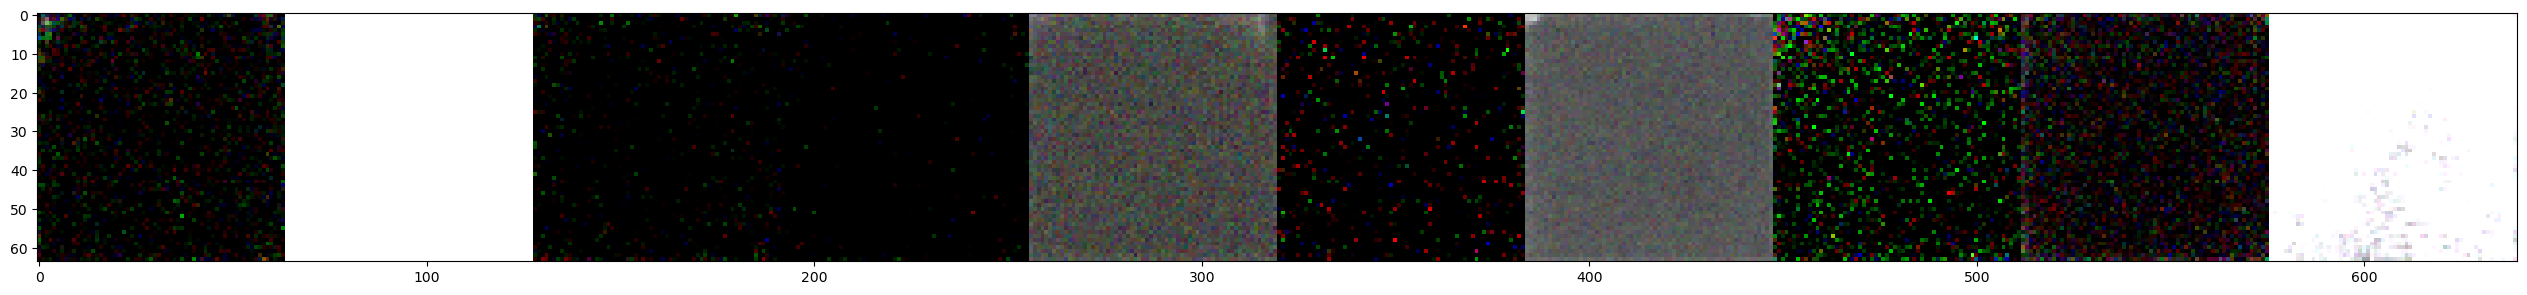

100%|██████████| 1500/1500 [01:57<00:00, 12.81it/s, MSE=0.0361]  
999it [01:46,  9.42it/s]
999it [01:46,  9.42it/s]


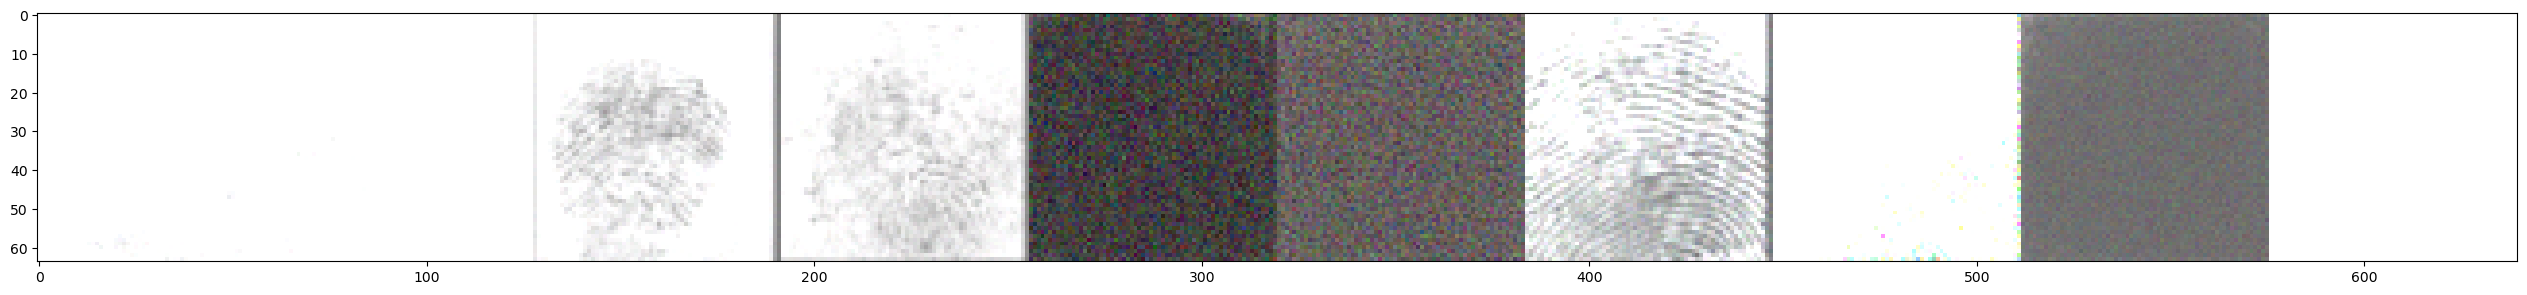

100%|██████████| 1500/1500 [01:56<00:00, 12.92it/s, MSE=0.00643] 
999it [01:46,  9.42it/s]
999it [01:46,  9.41it/s]


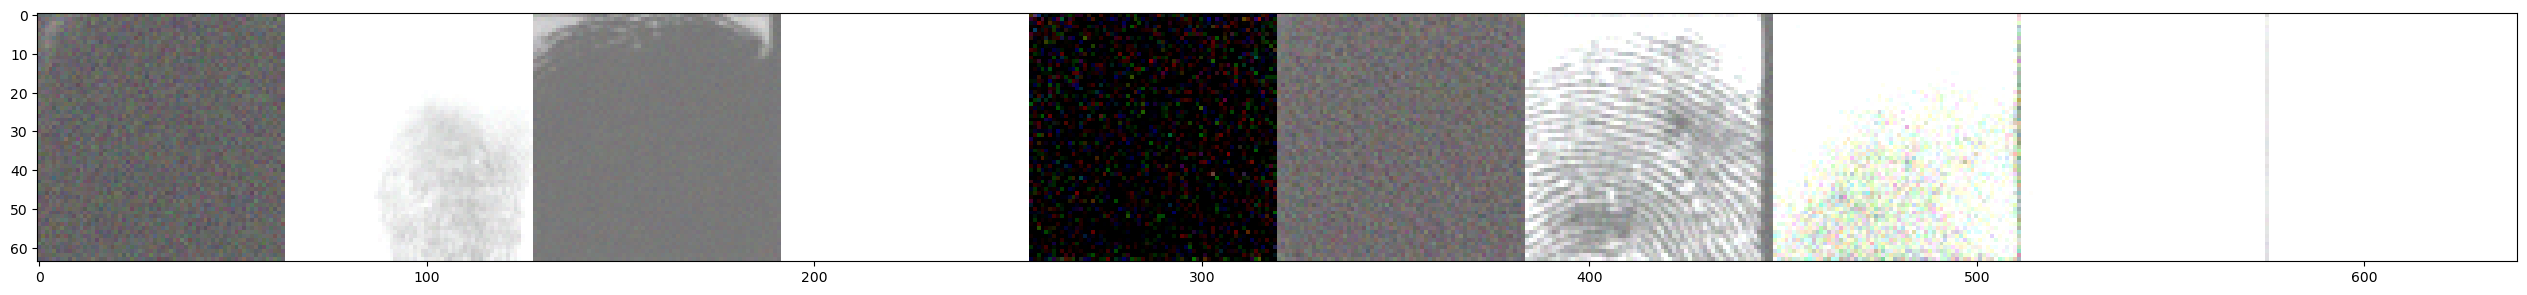

100%|██████████| 1500/1500 [01:56<00:00, 12.88it/s, MSE=0.00294] 
999it [01:46,  9.40it/s]
999it [01:46,  9.40it/s]


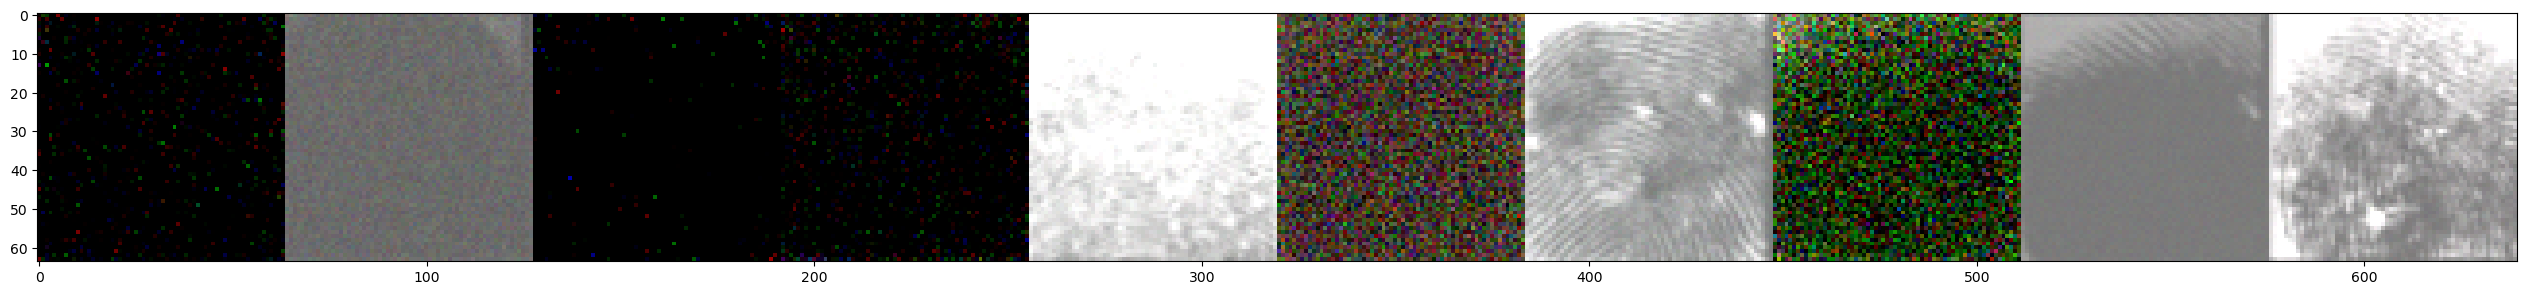

100%|██████████| 1500/1500 [01:56<00:00, 12.85it/s, MSE=0.0303]  
999it [01:46,  9.41it/s]
999it [01:46,  9.39it/s]


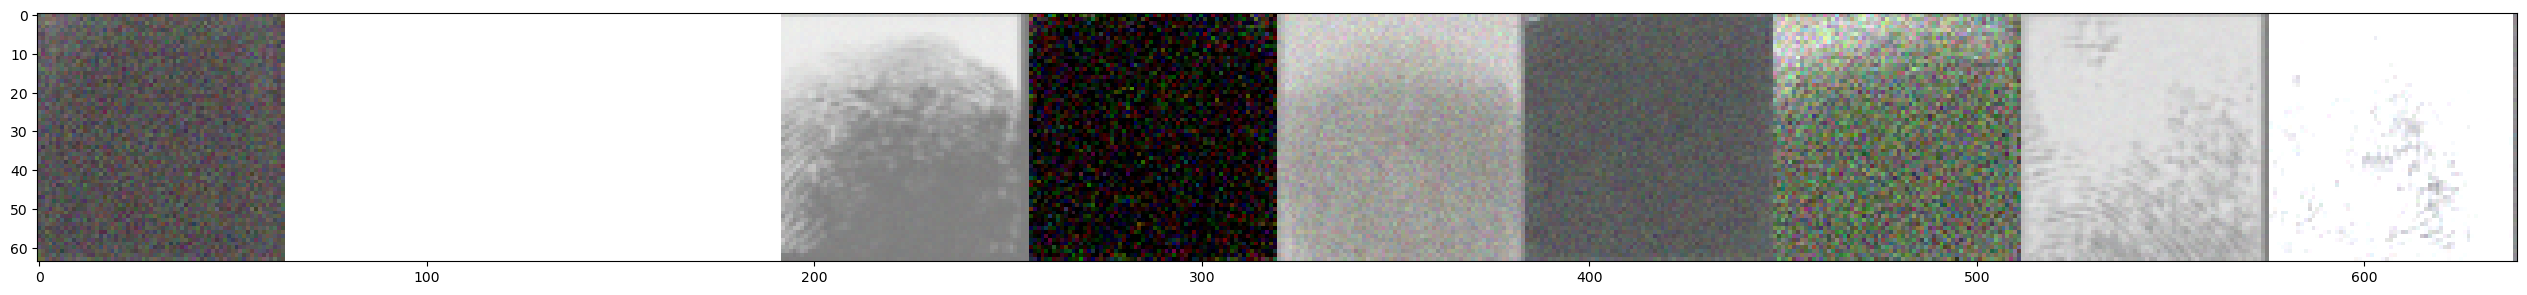

100%|██████████| 1500/1500 [01:57<00:00, 12.80it/s, MSE=0.00401] 
999it [01:46,  9.40it/s]
999it [01:46,  9.38it/s]


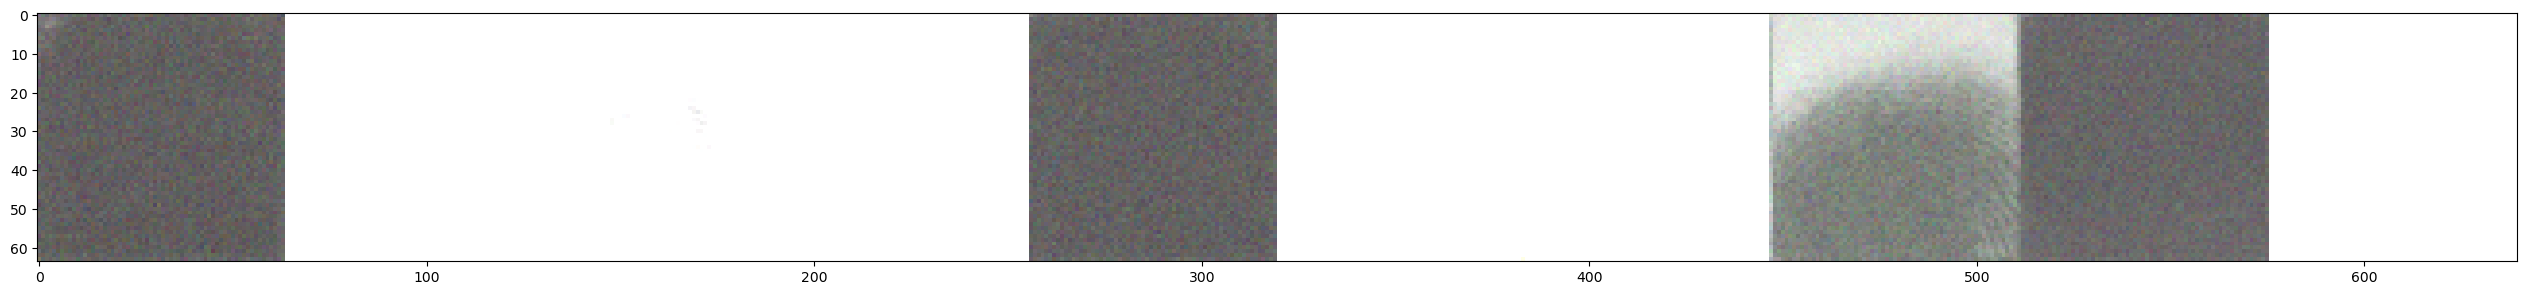

100%|██████████| 1500/1500 [01:56<00:00, 12.82it/s, MSE=0.00296] 
999it [01:46,  9.41it/s]
999it [01:46,  9.41it/s]


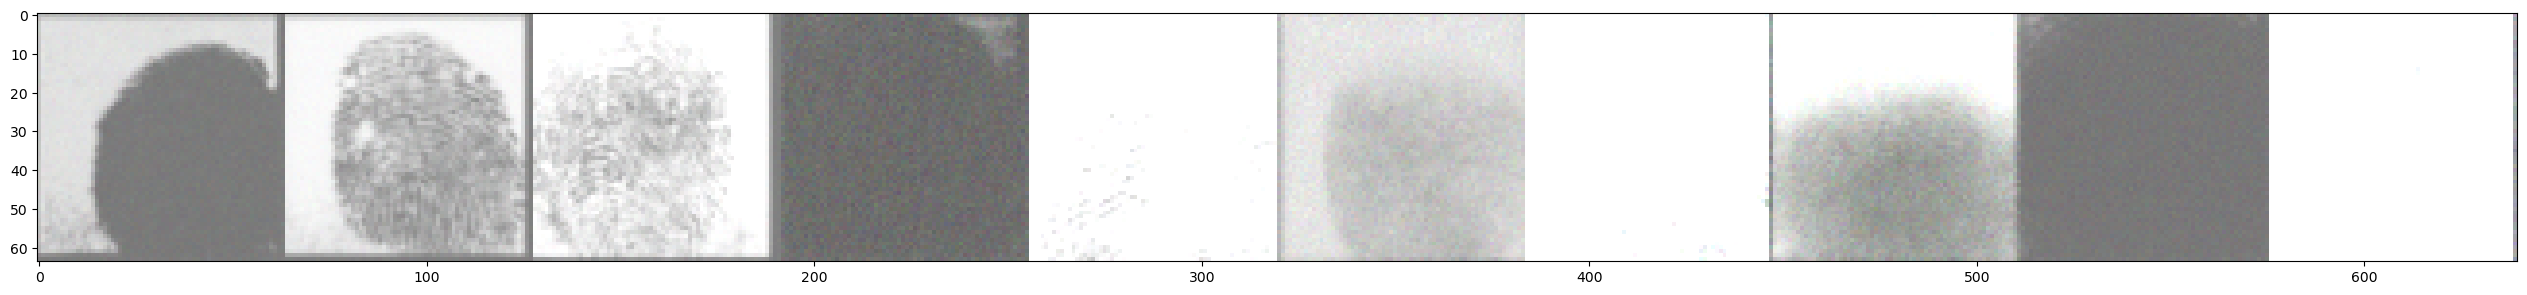

100%|██████████| 1500/1500 [01:56<00:00, 12.86it/s, MSE=0.00814] 
999it [01:46,  9.42it/s]
999it [01:46,  9.41it/s]


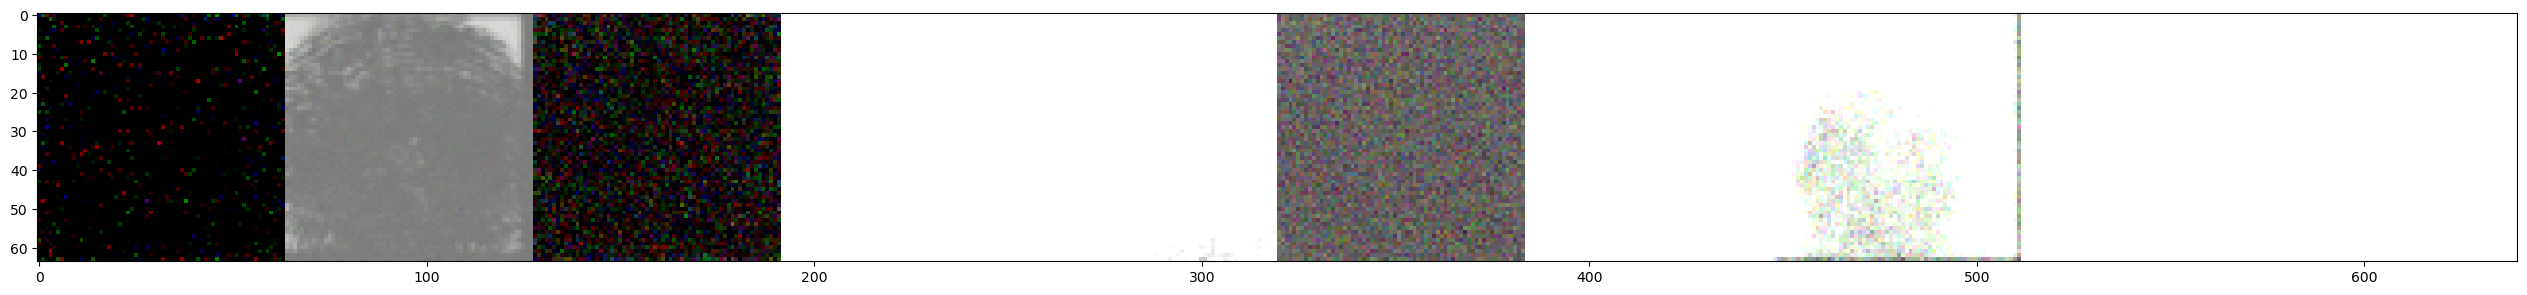

100%|██████████| 1500/1500 [01:57<00:00, 12.81it/s, MSE=0.0294]  
999it [01:46,  9.42it/s]
999it [01:45,  9.42it/s]


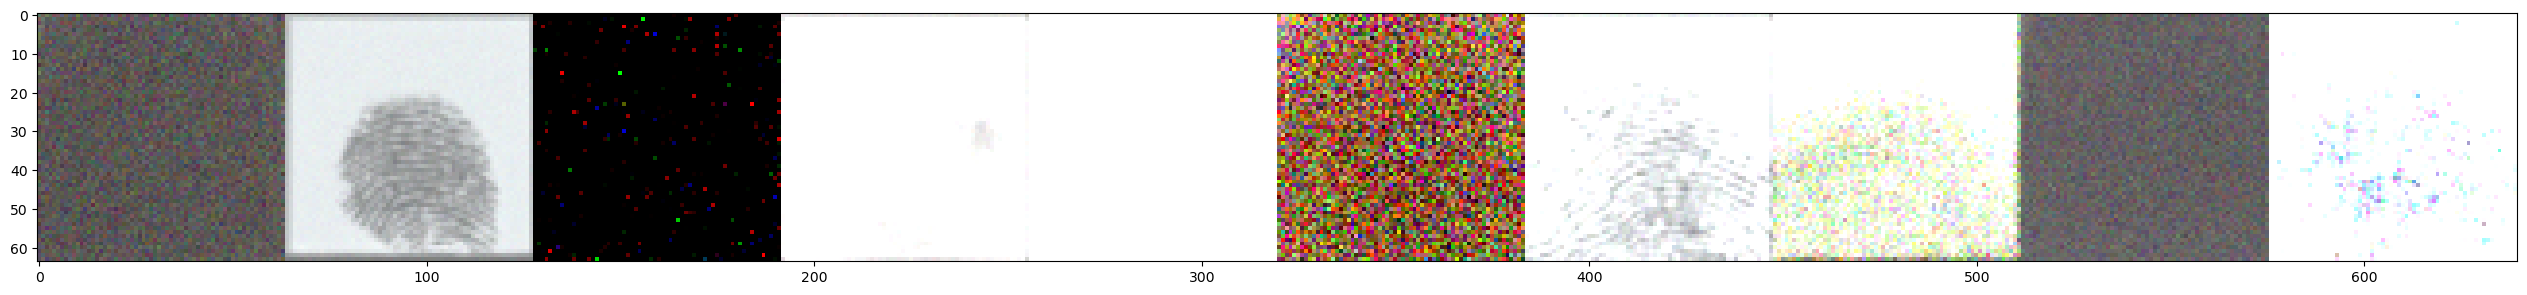

100%|██████████| 1500/1500 [01:56<00:00, 12.83it/s, MSE=0.0167]  
999it [01:46,  9.39it/s]
999it [01:46,  9.41it/s]


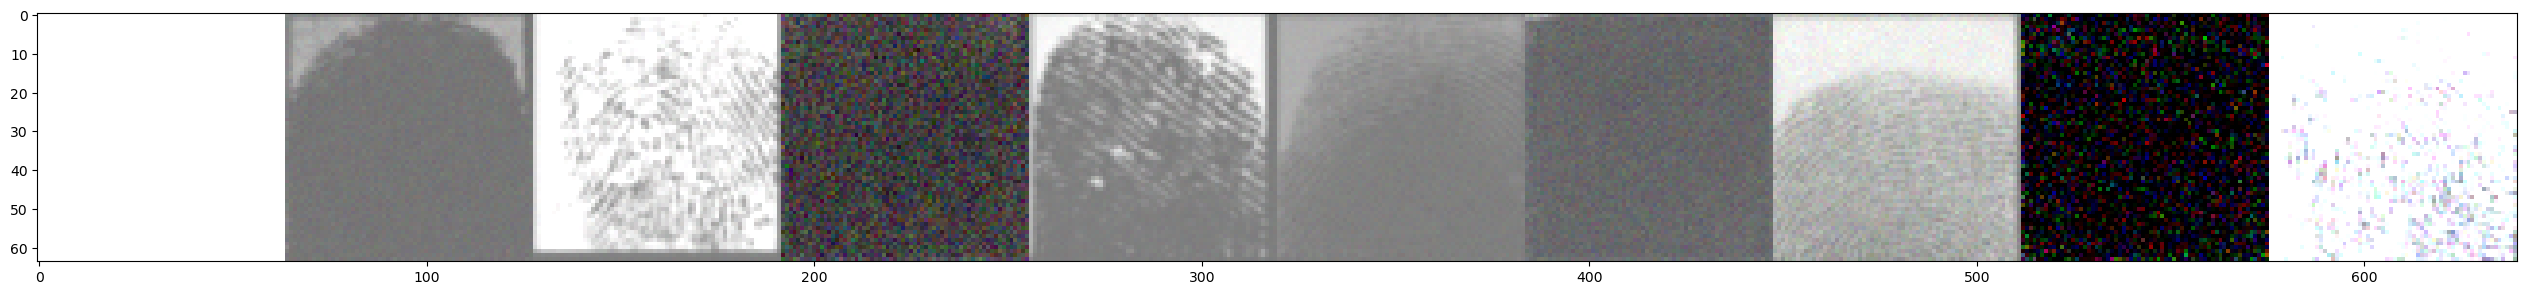

100%|██████████| 1500/1500 [01:56<00:00, 12.85it/s, MSE=0.000616]
999it [01:46,  9.42it/s]
999it [01:46,  9.41it/s]


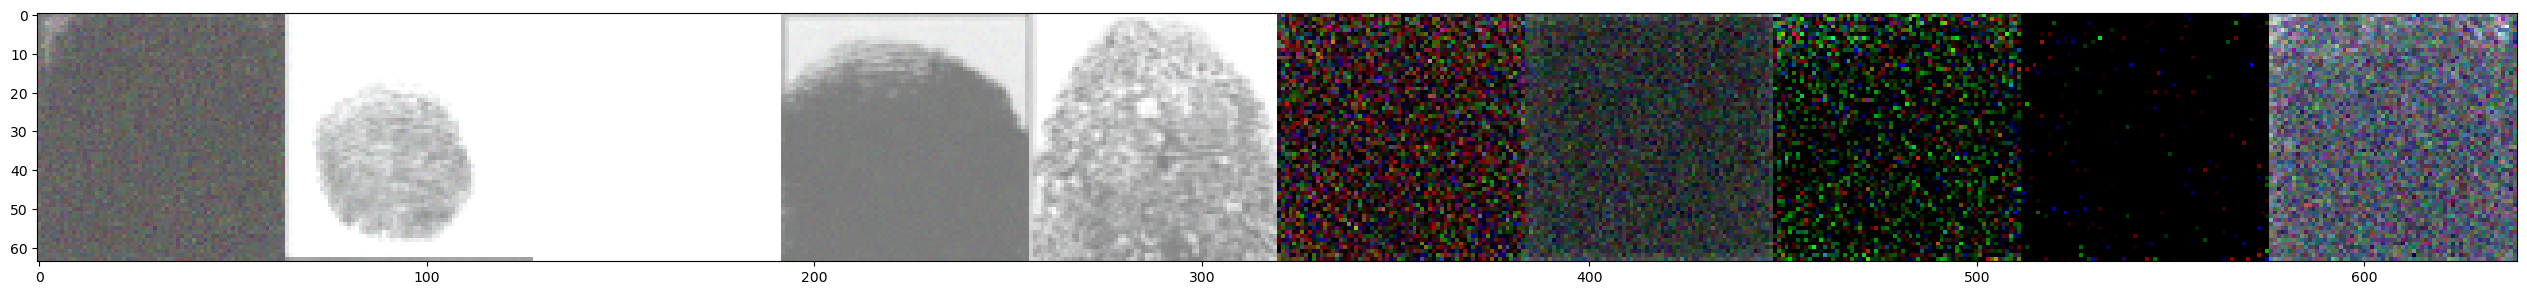

100%|██████████| 1500/1500 [01:56<00:00, 12.83it/s, MSE=0.015]   
999it [01:45,  9.43it/s]
999it [01:46,  9.40it/s]


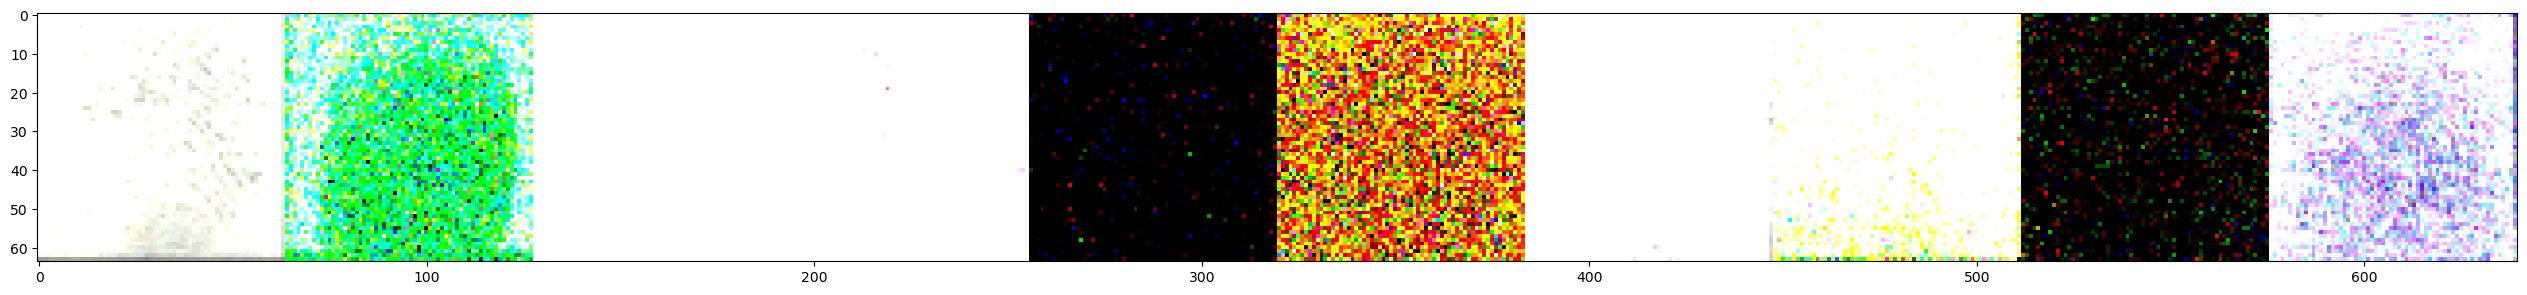

100%|██████████| 1500/1500 [01:56<00:00, 12.86it/s, MSE=0.000455]
999it [01:46,  9.42it/s]
999it [01:46,  9.39it/s]


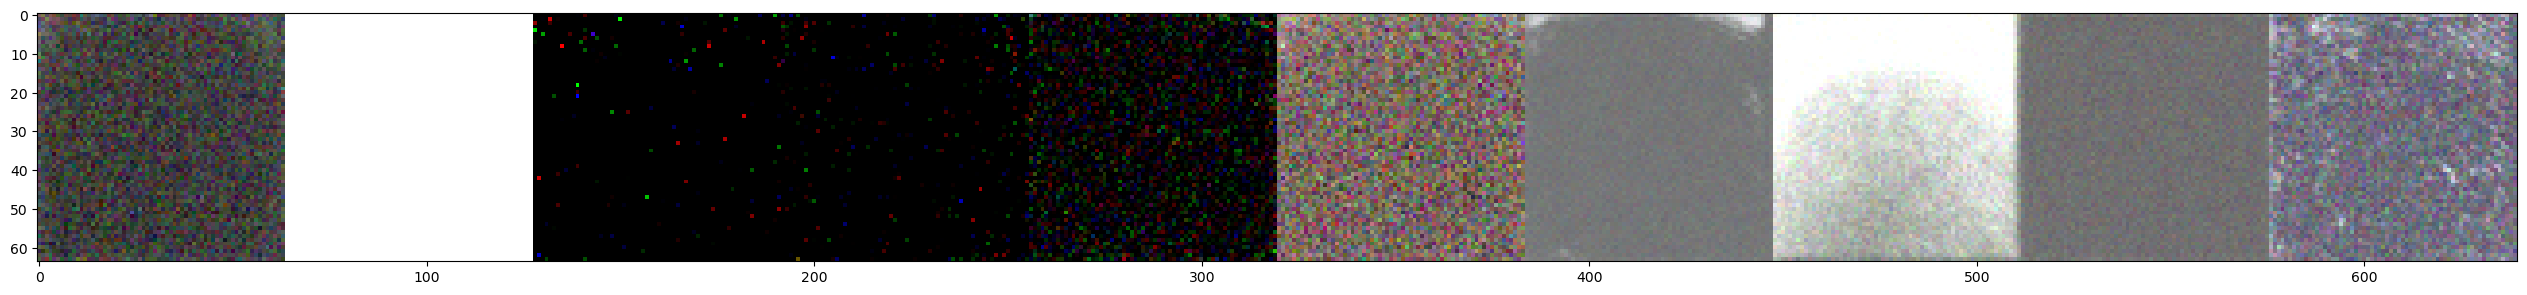

100%|██████████| 1500/1500 [01:55<00:00, 12.94it/s, MSE=0.00185] 
999it [01:46,  9.42it/s]
999it [01:46,  9.41it/s]


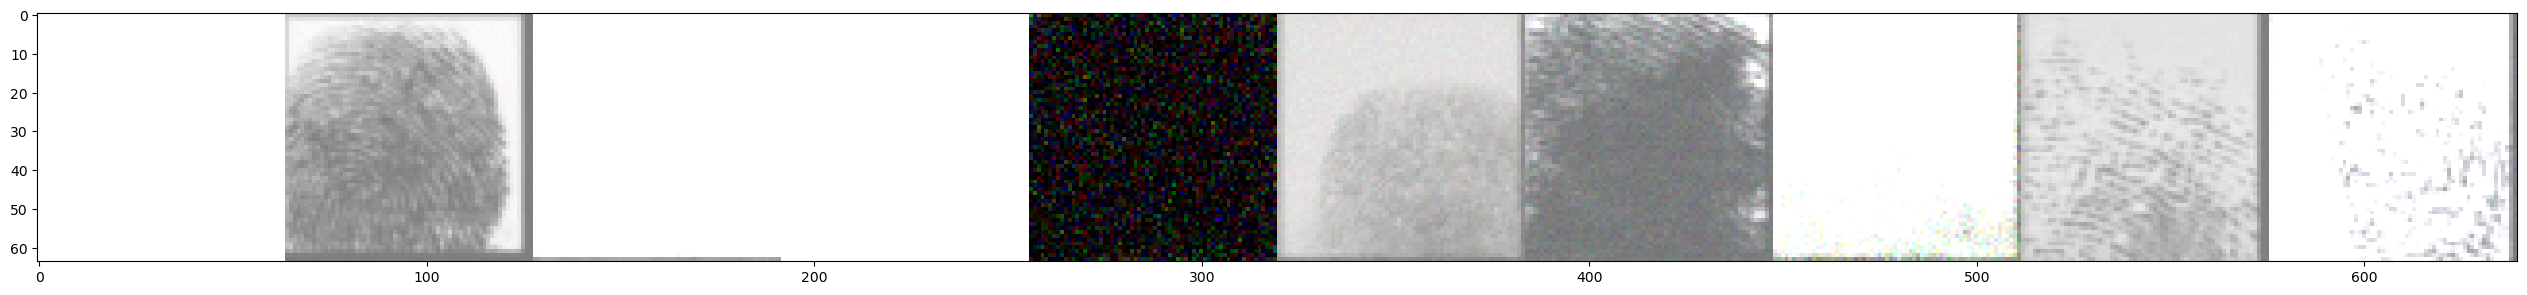

100%|██████████| 1500/1500 [01:56<00:00, 12.82it/s, MSE=0.0191]  
999it [01:46,  9.42it/s]
999it [01:46,  9.42it/s]


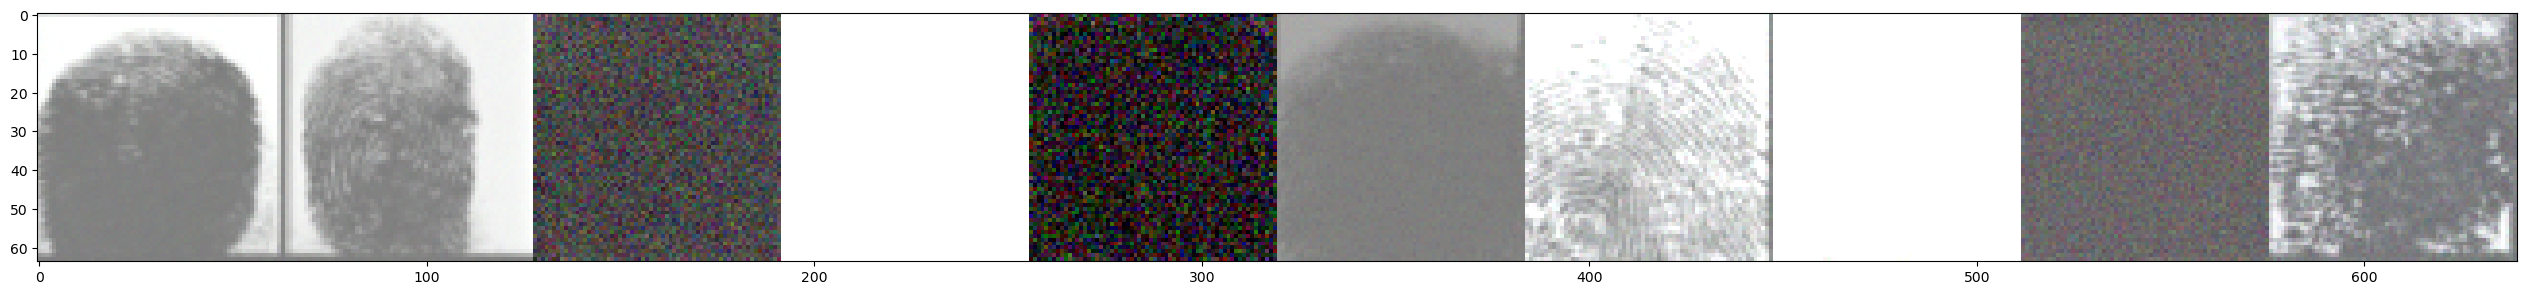

100%|██████████| 1500/1500 [01:56<00:00, 12.84it/s, MSE=0.0159]  
999it [01:46,  9.40it/s]
999it [01:46,  9.40it/s]


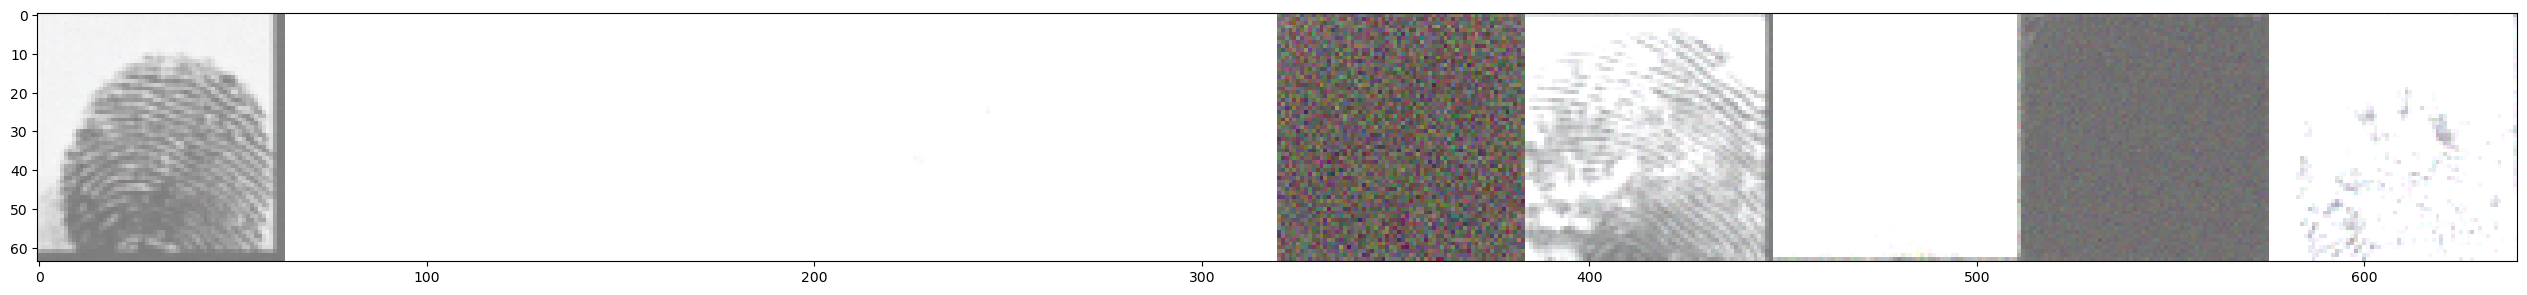

100%|██████████| 1500/1500 [01:56<00:00, 12.84it/s, MSE=0.0227]  
999it [01:46,  9.42it/s]
999it [01:46,  9.40it/s]


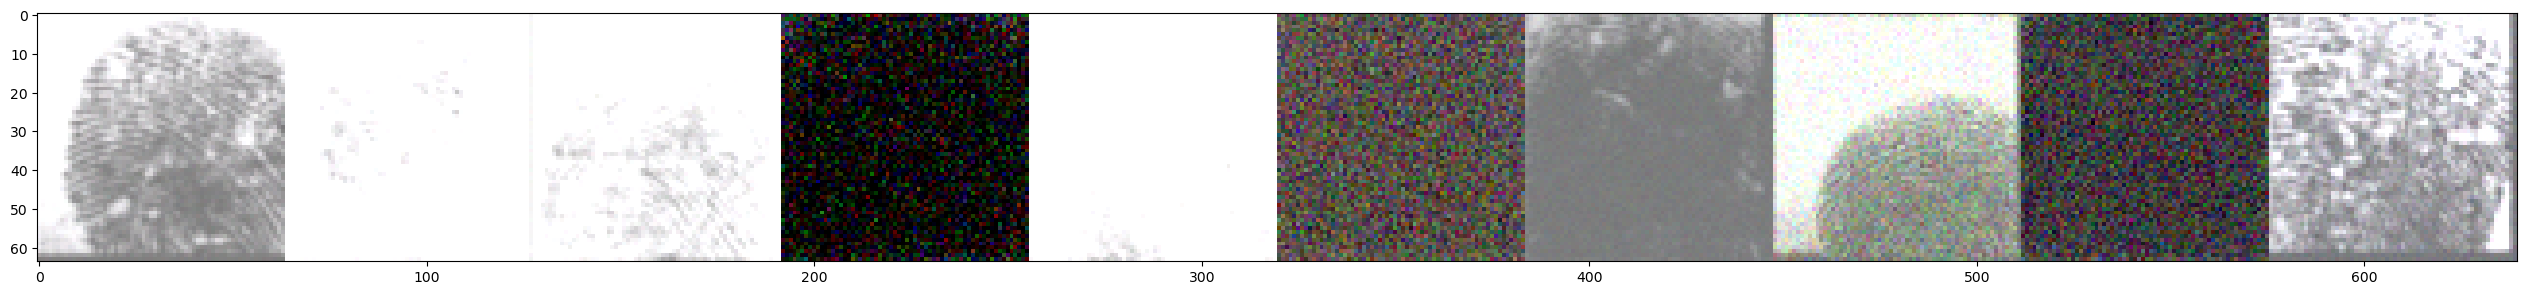

100%|██████████| 1500/1500 [01:57<00:00, 12.81it/s, MSE=0.0137]  
999it [01:46,  9.41it/s]
999it [01:46,  9.39it/s]


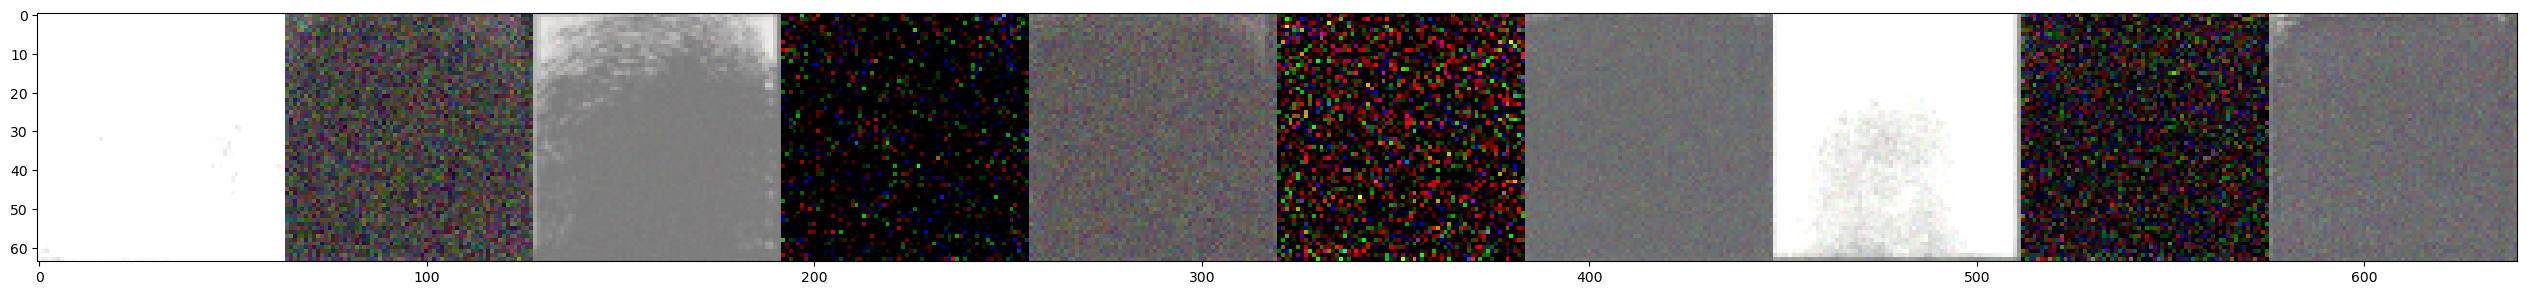

100%|██████████| 1500/1500 [01:56<00:00, 12.85it/s, MSE=0.0544]  
999it [01:46,  9.42it/s]
999it [01:46,  9.42it/s]


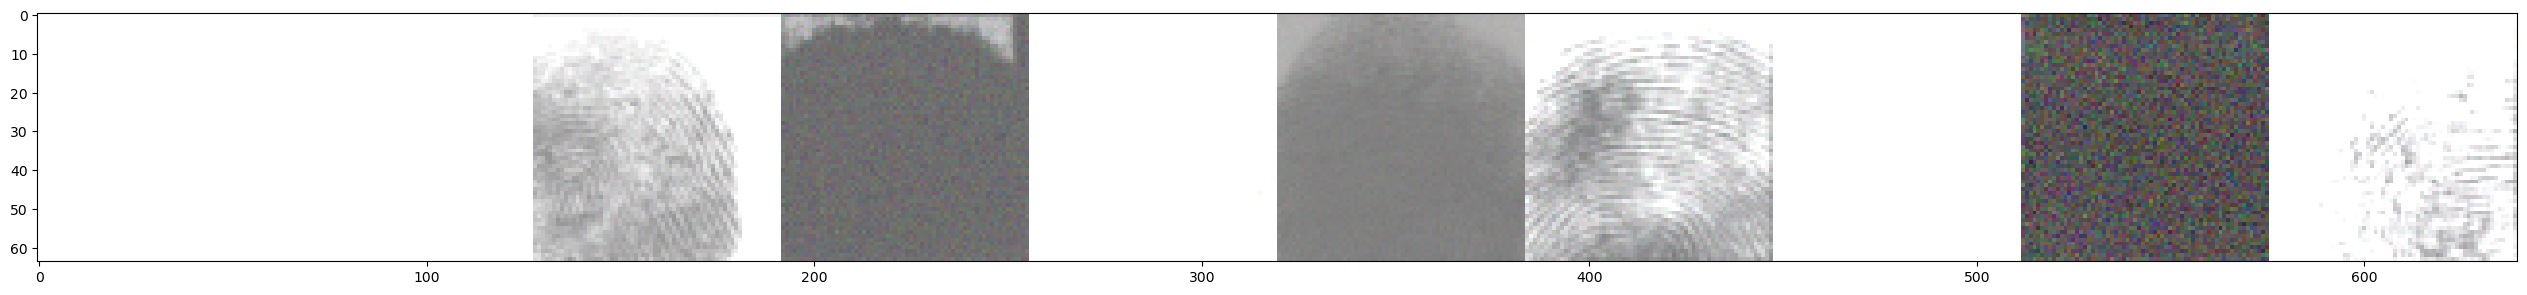

In [40]:
train()

In [ ]:
train()